Same process as Raven_skin-temp_correction.ipynb but using level2 data. Changes to files (variable names) seemed too any to keep track of in old file, just make a new one and change things.

In [1]:
import matplotlib.pyplot as plt
import datetime, time, math, cmocean, csv
import numpy as np
import netCDF4 as nc
from scipy import interpolate, stats
# from scipy import interpolate
import glob
from netCDF4 import Dataset
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')

In [2]:
def calc_skin_temp(lwd,lwu,emis):
    """ From Cox et al 2023: 'For snow, ε was set to 0.985, consistent with other studies (e.g., ref. 13) and justified by 
    the relatively spectrally flat hemispheric infrared emissivity of snow. For the wintertime snow surface, this assumption 
    is likely within 0.5% (~ 0.04 C at MOSAiC), but during summer when the surface type was variably ice, liquid, or melting 
    snow, the actual emissivity may have differed by more.' """
    sigma = 5.670374419*(10.**-8)
    Ts = ( (lwu - (1.-emis)*lwd)/(emis*sigma))**0.25
    return Ts

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""
    # from netCDF4 import Dataset

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()
    #print(out_vars.keys())
    return out_vars

In [4]:
def LWU_air_correction(LWU, T2M, TSFC):
    # based on SPLASH data, see LWUbias.png for 2m
    x = T2M - TSFC
    LWU_BIAS = 0.2899*x-0.03497
    LWU_CORR = LWU - LWU_BIAS
    return LWU_CORR, LWU_BIAS

In [5]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [6]:
# asfs_filepath_summ = '/psd3data/arctic/raven_process/asfs/level1/'
# asfs_summ_files = glob.glob(asfs_filepath_summ+'*slow*.nc')
# asfs_summ_files.sort()
# # asfs_summ_files = asfs_summ_files[8:]

In [7]:
fname = '/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240720.000000.nc'
open_netcdf = Dataset(fname, mode = 'r')
for var in open_netcdf.variables.keys():
    print(var)
open_netcdf.close()

base_time
time
time_offset
zenith_true
azimuth
sr50_dist
snow_depth
atmos_pressure
temp
rh
dew_point
mixing_ratio
vapor_pressure
rhi
brightness_temp_surface
skin_temp_surface
subsurface_heat_flux_A
subsurface_heat_flux_B
subsurface_heat_flux_C
wspd_u_mean
wspd_v_mean
wspd_w_mean
wspd_vec_mean
wdir_vec_mean
wspd_u_std
wspd_v_std
wspd_w_std
h2o_licor
co2_licor
down_long_hemisp
down_short_hemisp
up_long_hemisp
up_short_hemisp
down_short_direct
down_short_diffuse
snow_gpr_dist
lat
lon
heading
zenith_true_qc
azimuth_qc
sr50_dist_qc
snow_depth_qc
atmos_pressure_qc
temp_qc
rh_qc
dew_point_qc
mixing_ratio_qc
vapor_pressure_qc
rhi_qc
brightness_temp_surface_qc
skin_temp_surface_qc
subsurface_heat_flux_A_qc
subsurface_heat_flux_B_qc
wspd_u_mean_qc
wspd_v_mean_qc
wspd_w_mean_qc
wspd_vec_mean_qc
wdir_vec_mean_qc
h2o_licor_qc
co2_licor_qc
down_long_hemisp_qc
down_short_hemisp_qc
up_long_hemisp_qc
up_short_hemisp_qc
turbulence_qc
bulk_qc
Hs
Hl
CO2_flux
CO2_flux_Wm2
Cd
ustar
Tstar
zeta_level_n
WU_csp

In [8]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )




/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

asfs_data_lev2['skin_temp_surface'] = calc_skin_temp(asfs_data_lev2['down_long_hemisp'],asfs_data_lev2['up_long_hemisp'],0.985) - 273.15

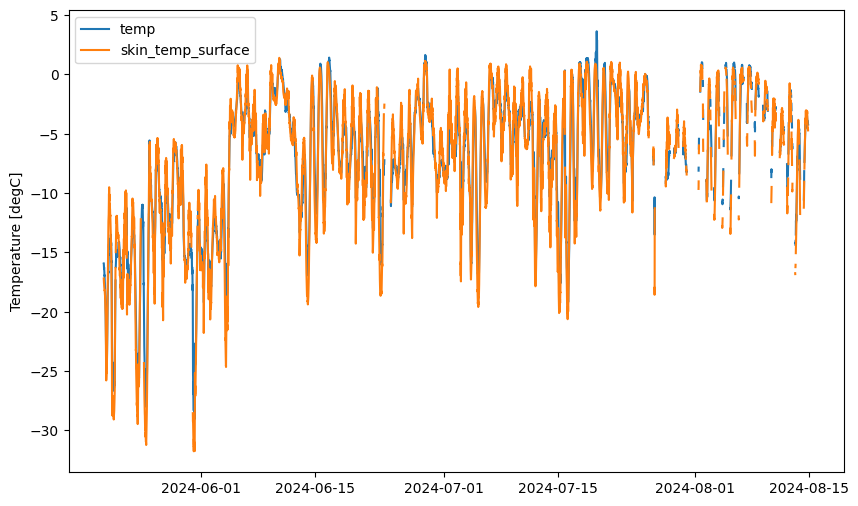

In [9]:
fig, ax = plt.subplots(1, figsize=(10,6))
for var in ['temp','skin_temp_surface']:
    pltvar = asfs_data_lev2[var]
    plt.plot(asfs_data_lev2['dates'], pltvar, label=var)
plt.legend(loc='best')
plt.ylabel('Temperature [degC]')
# plt.xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,5,25))
plt.show()

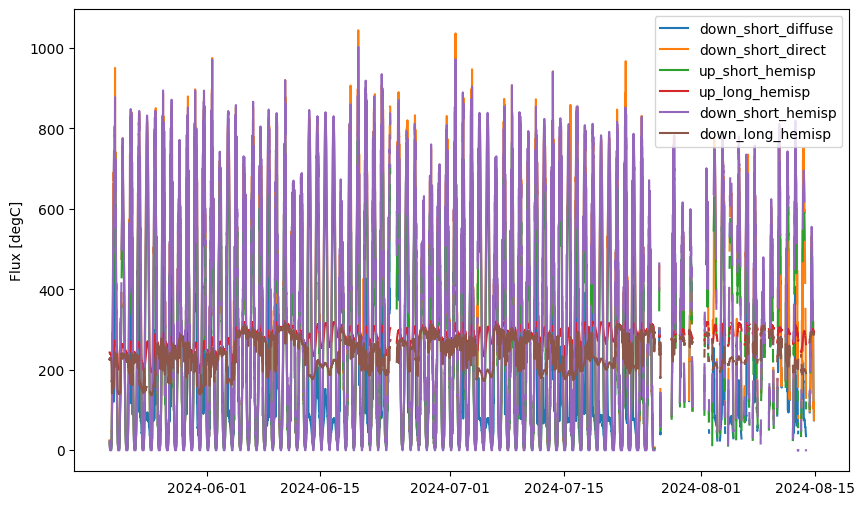

In [10]:
fig, ax = plt.subplots(1, figsize=(10,6))
for var in ['down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp']:
    pltvar = asfs_data_lev2[var]
    plt.plot(asfs_data_lev2['dates'], pltvar, label=var)
plt.legend(loc='best')
plt.ylabel('Flux [degC]')
# plt.xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,5,25))
plt.show()

In [11]:
# first apply air correction (step 2)
lwu_air_corr, lwu_air_bias = LWU_air_correction(asfs_data_lev2['up_long_hemisp'], asfs_data_lev2['temp'], asfs_data_lev2['skin_temp_surface'])

In [12]:
asfs_data_lev2['deltaT'] = asfs_data_lev2['temp'] - asfs_data_lev2['skin_temp_surface']
asfs_data_lev2['lwu_air_corr'] = lwu_air_corr
asfs_data_lev2['lwu_air_bias'] = lwu_air_bias

In [13]:
labels = {'deltaT':{'ylabel':'T2m - Tsfc', 'legend':''}, 'up_long_hemisp':{'ylabel':'LWU [W m-2]', 'legend':'raw'},
         'lwu_air_corr':{'ylabel':'LWU [W m-2]', 'legend':'air correction'}}

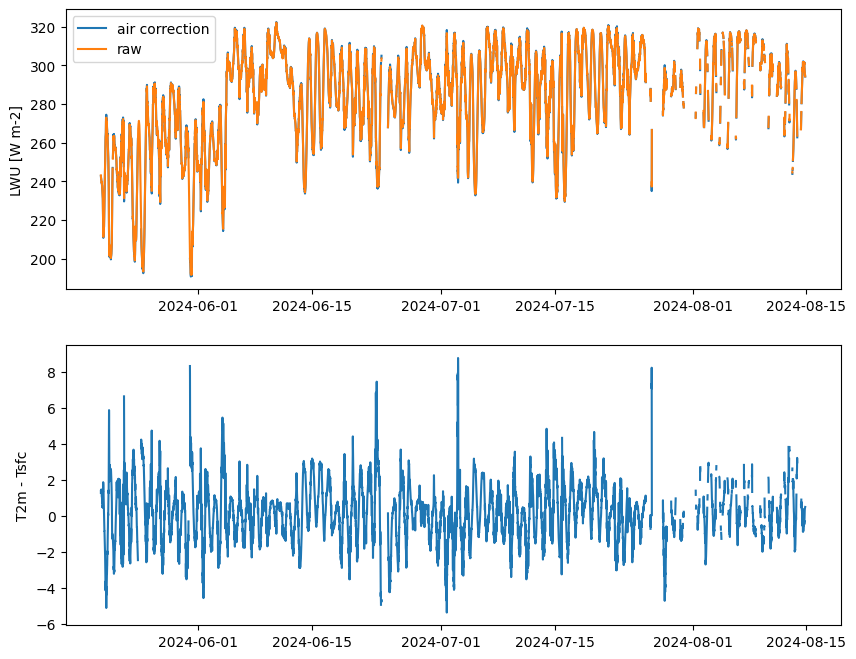

In [14]:
fig, axs = plt.subplots(2, figsize=(10,8))


for ax, varname in zip(axs.ravel(), ['lwu_air_corr', 'deltaT']):
    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2[varname], label=labels[varname]['legend'])
    ax.set_ylabel(labels[varname]['ylabel'])

axs[0].plot(asfs_data_lev2['dates'], asfs_data_lev2['up_long_hemisp'], label=labels['up_long_hemisp']['legend'])
axs[0].legend(loc='best')
plt.show()

In [15]:
## recalculate skin temperature to see if it's any better
Ts_air_corr = calc_skin_temp(asfs_data_lev2['down_long_hemisp'],asfs_data_lev2['lwu_air_corr'],0.985)
asfs_data_lev2['Ts_air_corr'] = Ts_air_corr - 273.15

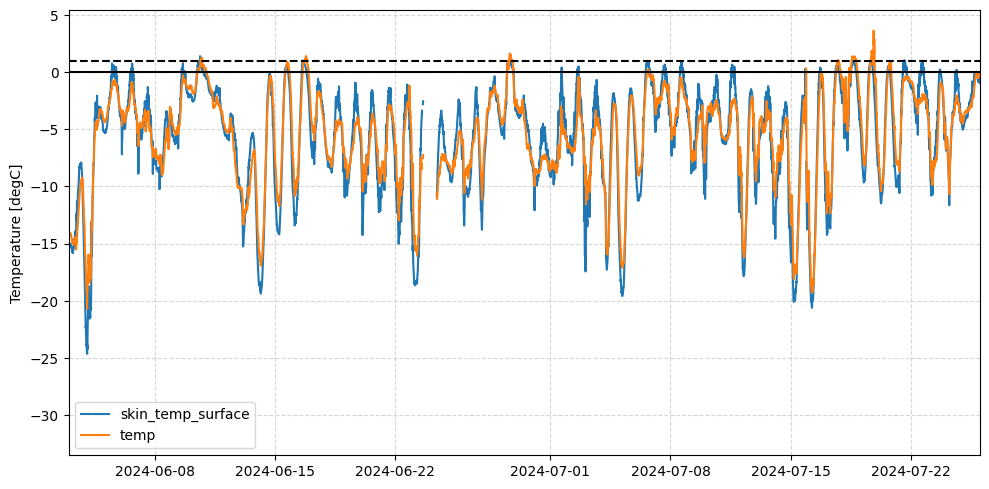

In [16]:
fig, ax = plt.subplots(1, figsize=(10,5))

for varname in ['skin_temp_surface','temp']:
    plt.plot(asfs_data_lev2['dates'], asfs_data_lev2[varname], label=varname)

plt.xlim(datetime.datetime(2024,6,3),datetime.datetime(2024,7,26))
plt.legend(loc='best')
plt.axhline(y=0, c='k')
plt.axhline(y=1, c='k', ls='--')
plt.grid(ls='--', alpha=.5)
# plt.ylim(-25,4)
plt.ylabel('Temperature [degC]')
plt.tight_layout()
# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_timeseries_skin-2m-temps.png')
plt.show()

### Sanity check: SPN total and SWD as sanity check

In [17]:
asfs_data_lev2['spn1_tot_Avg'] = asfs_data_lev2['down_short_direct']#asfs_data_lev2['down_short_diffuse']#+

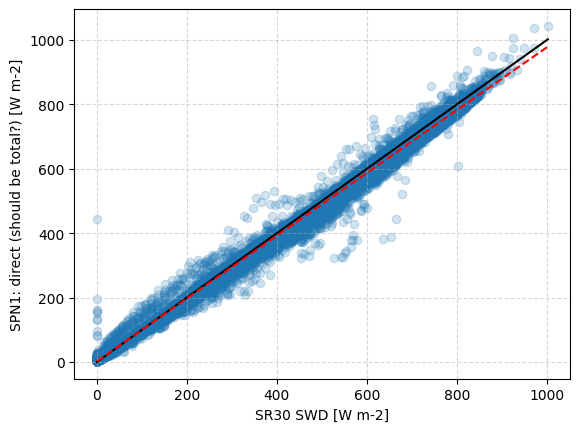

In [18]:
plt.scatter(asfs_data_lev2['down_short_hemisp'], asfs_data_lev2['spn1_tot_Avg'], alpha=.2)

minval = min(asfs_data_lev2['down_short_hemisp'].min(), asfs_data_lev2['down_short_hemisp'].min())
maxval = min(asfs_data_lev2['down_short_hemisp'].max(), asfs_data_lev2['down_short_hemisp'].max())

plt.plot([minval, maxval],[minval, maxval], c='k')
xs = asfs_data_lev2['down_short_hemisp']
ys_lr = asfs_data_lev2['spn1_tot_Avg']
plt.plot(np.ma.unique(xs), np.poly1d(np.ma.polyfit(xs, ys_lr, 1))(np.ma.unique(xs)), c='r', ls='--')

plt.xlabel('SR30 SWD [W m-2]')
plt.ylabel('SPN1: direct (should be total?) [W m-2]')
plt.grid(alpha=.5, ls='--')
# plt.savefig('Raven2024_SR30-SWD_SPN1-TOT.png', dpi=250)
plt.show()

### Try SW correction because the air temperature didn't change it

In [19]:
# save fraction of diffuse/total from SPN
asfs_data_lev2['diffuse_frac'] = asfs_data_lev2['down_short_diffuse']/asfs_data_lev2['down_short_direct']

asfs_data_lev2['albedo'] = asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']
asfs_data_lev2['SWN'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']

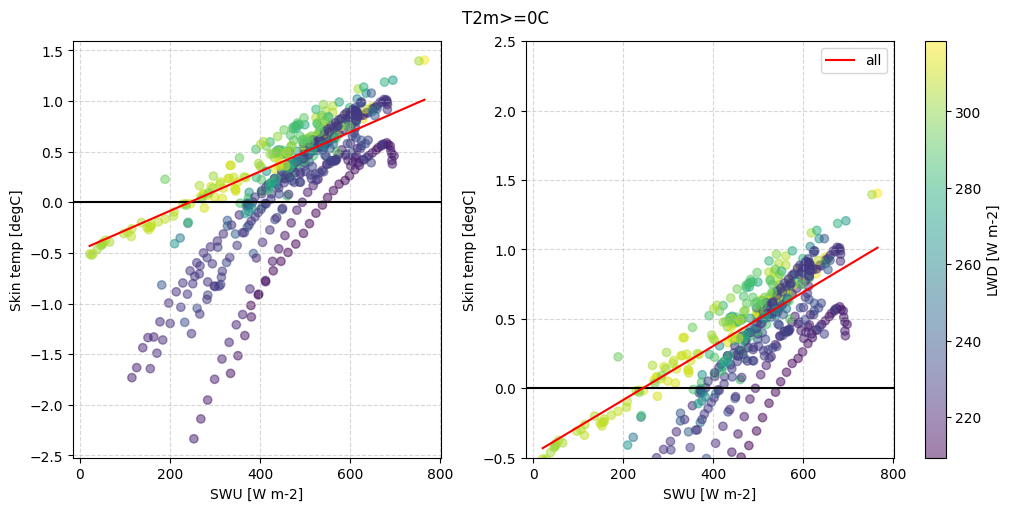

In [20]:
T2m_idx = warm_idx = np.where(asfs_data_lev2['temp']>=0)[0]
fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)

# xs = np.ma.masked_outside(asfs_data_lev2['sr30_swd_IrrC_Avg'][T2m_idx], 0,2000)-np.ma.masked_outside(asfs_data_lev2['sr30_swu_IrrC_Avg'][T2m_idx], 0,2000)
xs = np.ma.masked_outside(asfs_data_lev2['up_short_hemisp'][T2m_idx], 0,2000)

ys = asfs_data_lev2['skin_temp_surface'][T2m_idx]
cs = asfs_data_lev2['down_long_hemisp'][T2m_idx]

ys_lr = np.ma.masked_less(ys, 0)

for ax in axs.ravel():
    cb = ax.scatter(xs, 
                    ys, alpha=.5, c=cs)
    ax.set_xlabel('SWU [W m-2]')
    ax.set_ylabel('Skin temp [degC]')
    ax.grid(alpha=.5, ls='--')
    ax.axhline(y=0, c='k')

    # make two best fit lines based on diffuse/total
    ax.plot(np.ma.unique(xs), np.poly1d(np.ma.polyfit(xs, ys_lr, 1))(np.ma.unique(xs)), c='r', label='all')
    # ax.plot(np.ma.unique(xs), np.poly1d(np.ma.polyfit(np.ma.masked_where(cs>.5,xs), ys_lr, 1))(np.ma.unique(xs)), c='m', label='dif/tot<=.5')
    # ax.plot(np.ma.unique(xs), np.poly1d(np.ma.polyfit(np.ma.masked_where(cs<=.5,xs), ys_lr, 1))(np.ma.unique(xs)), c='b', label='dif/tot>.5')
axs[1].legend(loc='best')
plt.colorbar(cb, label='LWD [W m-2]', ax=axs[1])

axs[1].set_ylim(-0.5,2.5)

# plt.legend(loc='best')

fig.suptitle('T2m>=0C')
# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT_LWDccbar_warmT2m.png')

plt.show()

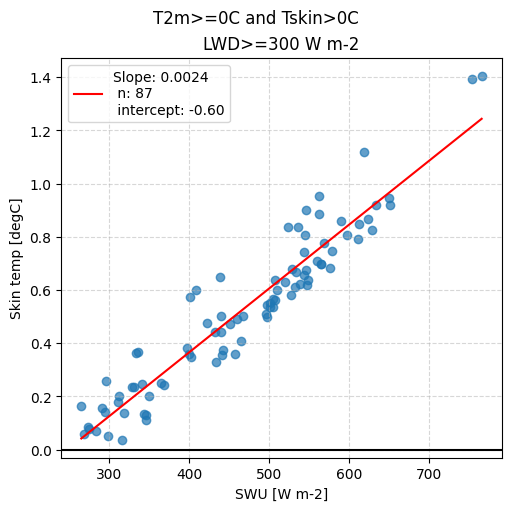

In [21]:
warm_idx = np.where( (asfs_data_lev2['temp']>=0)&(asfs_data_lev2['skin_temp_surface']>0) )[0]

xs = np.ma.masked_outside(asfs_data_lev2['up_short_hemisp'][warm_idx], 0,2000)
ys = asfs_data_lev2['skin_temp_surface'][warm_idx]

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5,5))


# for lower, upper, ax in zip(lwd_bins[:-1], lwd_bins[1:], axs.ravel()):
a_idx = np.where( asfs_data_lev2['down_long_hemisp'][warm_idx]>=300 )[0]
a_xs = xs[a_idx]
a_ys = ys[a_idx]

ax.scatter(a_xs, a_ys, alpha=.7)
slope, b = np.ma.polyfit(a_xs, a_ys, 1)
lwd_300_intercept = b
lwd_300_slope = slope
ax.plot(np.ma.unique(a_xs), np.poly1d(np.ma.polyfit(a_xs, a_ys, 1))(np.ma.unique(a_xs)), c='r', 
        label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, a_xs.count(), b))

ax.set_xlabel('SWU [W m-2]')
ax.set_ylabel('Skin temp [degC]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=0, c='k')
ax.set_title('LWD>=300 W m-2')
ax.legend(loc='best')


fig.suptitle('T2m>=0C and Tskin>0C')

# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT-regressions_5LWD-bins.png')

plt.show()

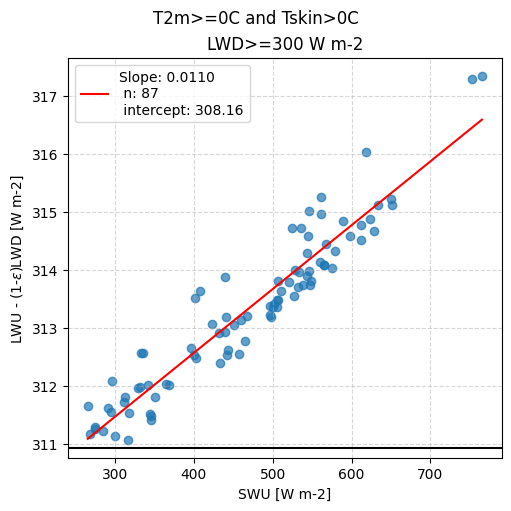

In [22]:
epsilon = 0.985
sigma = 5.670374419*(10.**-8)

warm_idx = np.where( (asfs_data_lev2['temp']>=0)&(asfs_data_lev2['skin_temp_surface']>0) )[0]

xs = np.ma.masked_outside(asfs_data_lev2['up_short_hemisp'][warm_idx], 0,2000)
ys = (asfs_data_lev2['up_long_hemisp']-(1.-epsilon)*asfs_data_lev2['down_long_hemisp'])[warm_idx]

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5,5))


# for lower, upper, ax in zip(lwd_bins[:-1], lwd_bins[1:], axs.ravel()):
a_idx = np.where( asfs_data_lev2['down_long_hemisp'][warm_idx]>=300 )[0]
a_xs = xs[a_idx]
a_ys = ys[a_idx]

ax.scatter(a_xs, a_ys, alpha=.7)
slope, b = np.ma.polyfit(a_xs, a_ys, 1)
flx_lwd_300_intercept = b
flx_lwd_300_slope = slope
ax.plot(np.ma.unique(a_xs), np.poly1d(np.ma.polyfit(a_xs, a_ys, 1))(np.ma.unique(a_xs)), c='r', 
        label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, a_xs.count(), b))

ax.set_xlabel('SWU [W m-2]')
ax.set_ylabel('LWU - (1-$\epsilon$)LWD [W m-2]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=273.15**4*epsilon*sigma, c='k')
ax.set_title('LWD>=300 W m-2')
ax.legend(loc='best')


fig.suptitle('T2m>=0C and Tskin>0C')

# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT-regressions_5LWD-bins.png')

plt.show()

In [23]:
## bias in LW used for Tskin relative to what tskin should be when the surface is melting
delta_LW = (asfs_data_lev2['up_long_hemisp']-(1.-epsilon)*asfs_data_lev2['down_long_hemisp'])[warm_idx] - 273.15**4*epsilon*sigma

## complicated x for getting the slope to be what I want
x_SW = (asfs_data_lev2['up_short_hemisp'] - (1. - epsilon)*asfs_data_lev2['down_short_hemisp'])[warm_idx]



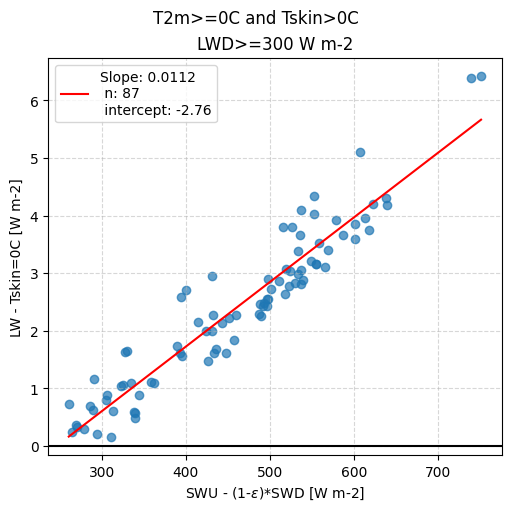

In [24]:
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5,5))

ax.scatter(x_SW[a_idx], delta_LW[a_idx], alpha=.7)
slope, b = np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1)
flx_lw_300_intercept = b
flx_lw_300_slope = slope
ax.plot(np.ma.unique(x_SW[a_idx]), np.poly1d(np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1))(np.ma.unique(x_SW[a_idx])), c='r', 
        label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, x_SW[a_idx].count(), b))

ax.set_xlabel('SWU - (1-$\epsilon$)*SWD [W m-2]')
ax.set_ylabel('LW - Tskin=0C [W m-2]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=0, c='k')
ax.set_title('LWD>=300 W m-2')
ax.legend(loc='best')


fig.suptitle('T2m>=0C and Tskin>0C')

# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT-regressions_5LWD-bins.png')

plt.show()

## Diversion for Polar AMS 2025 poster 

In [26]:
## bias in LW used for Tskin relative to what tskin should be when the surface is melting
delta_LW_all = (asfs_data_lev2['up_long_hemisp']-(1.-epsilon)*asfs_data_lev2['down_long_hemisp']) - 273.15**4*epsilon*sigma

## complicated x for getting the slope to be what I want
x_SW_all = (asfs_data_lev2['up_short_hemisp'] - (1. - epsilon)*asfs_data_lev2['down_short_hemisp'])


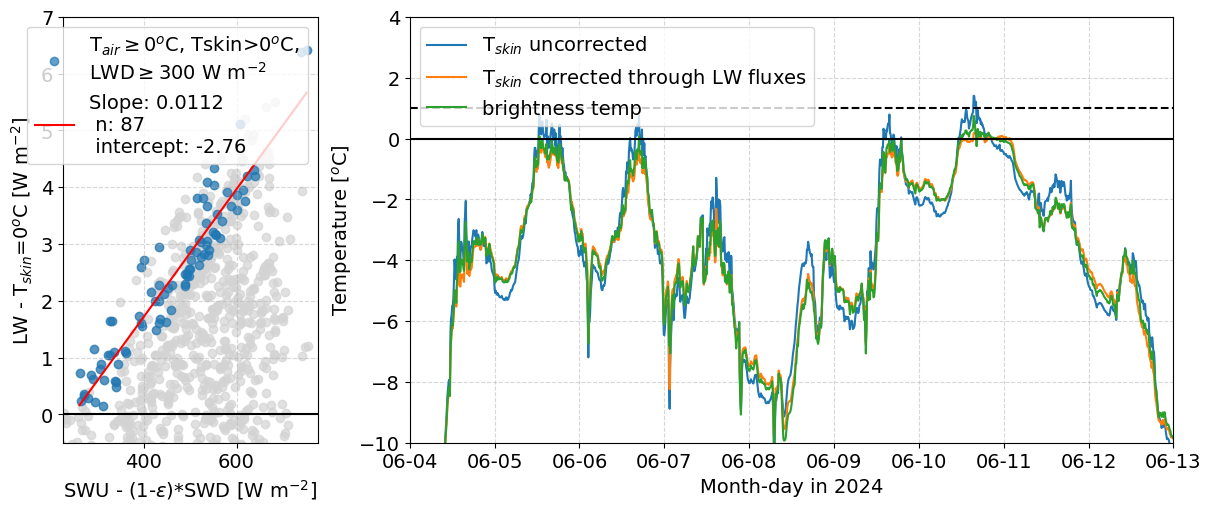

In [53]:
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(12,5), gridspec_kw=dict(width_ratios=[1,3]))

axs[0].scatter(x_SW_all, delta_LW_all, alpha=.7, c='lightgray')

axs[0].scatter(x_SW[a_idx], delta_LW[a_idx], alpha=.7, label='T$_{air}$$\geq$0$^o$C, Tskin>0$^o$C,\nLWD$\geq$300 W m$^{-2}$')
slope, b = np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1)
flx_lw_300_intercept = b
flx_lw_300_slope = slope
axs[0].plot(np.ma.unique(x_SW[a_idx]), np.poly1d(np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1))(np.ma.unique(x_SW[a_idx])), c='r', 
        label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, x_SW[a_idx].count(), b))

axs[0].set_xlabel('SWU - (1-$\epsilon$)*SWD [W m$^{-2}$]')
axs[0].set_ylabel('LW - T$_{skin}$=0$^o$C [W m$^{-2}$]')
axs[0].grid(alpha=.5, ls='--')
axs[0].axhline(y=0, c='k')
axs[0].legend(loc='best')

axs[0].set_ylim(-.5,7)
axs[0].set_xlim(225,775)

axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='T$_{skin}$ uncorrected')
axs[1].plot(asfs_data_lev2['dates'], tskin_lw_correction-273.15, label='T$_{skin}$ corrected through LW fluxes')
axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['brightness_temp_surface'], label='brightness temp')

axs[1].set_xlim(datetime.datetime(2024,6,4),datetime.datetime(2024,6,13))
axs[1].legend(loc='best')
axs[1].axhline(y=0, c='k')
axs[1].axhline(y=1, c='k', ls='--')
axs[1].grid(ls='--', alpha=.5)
# plt.ylim(-25,4)
axs[1].set_ylim(-10,4)
axs[1].set_ylabel('Temperature [$^o$C]')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_xlabel('Month-day in 2024')

# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT-regressions_5LWD-bins.png')

plt.show()

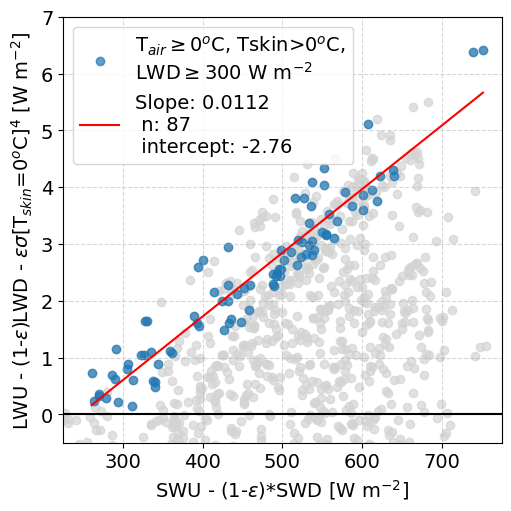

In [67]:
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(1, constrained_layout=True, figsize=(5,5))

axs.scatter(x_SW_all, delta_LW_all, alpha=.7, c='lightgray')

axs.scatter(x_SW[a_idx], delta_LW[a_idx], alpha=.7, label='T$_{air}$$\geq$0$^o$C, Tskin>0$^o$C,\nLWD$\geq$300 W m$^{-2}$')
slope, b = np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1)
flx_lw_300_intercept = b
flx_lw_300_slope = slope
axs.plot(np.ma.unique(x_SW[a_idx]), np.poly1d(np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1))(np.ma.unique(x_SW[a_idx])), c='r', 
        label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, x_SW[a_idx].count(), b))

axs.set_xlabel('SWU - (1-$\epsilon$)*SWD [W m$^{-2}$]')
axs.set_ylabel('LWU - (1-$\epsilon$)LWD - $\epsilon$$\sigma$[T$_{skin}$=0$^o$C$]^4$ [W m$^{-2}$]')
axs.grid(alpha=.5, ls='--')
axs.axhline(y=0, c='k')
axs.legend(loc='best')

axs.set_ylim(-.5,7)
axs.set_xlim(225,775)

# axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='T$_{skin}$ uncorrected')
# axs[1].plot(asfs_data_lev2['dates'], tskin_lw_correction-273.15, label='T$_{skin}$ corrected through LW fluxes')
# axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['brightness_temp_surface'], label='brightness temp')

# axs[1].set_xlim(datetime.datetime(2024,6,4),datetime.datetime(2024,6,13))
# axs[1].legend(loc='best')
# axs[1].axhline(y=0, c='k')
# axs[1].axhline(y=1, c='k', ls='--')
# axs[1].grid(ls='--', alpha=.5)
# # plt.ylim(-25,4)
# axs[1].set_ylim(-10,4)
# axs[1].set_ylabel('Temperature [$^o$C]')
# axs[1].xaxis.set_major_formatter(myFmt)
# axs[1].set_xlabel('Month-day in 2024')

plt.savefig('/home/asledd/ICECAPS/polarAMS2025/Raven_2024_SWU-LW-skinT-regressions.png', dpi=300)

plt.show()

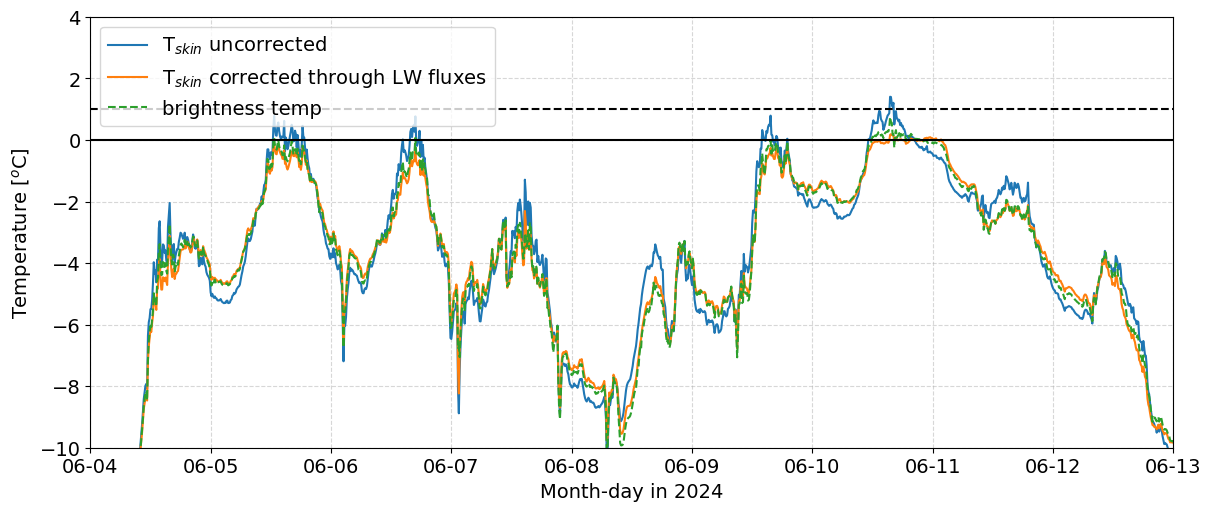

In [65]:
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(1, constrained_layout=True, figsize=(12,5))

# axs.scatter(x_SW_all, delta_LW_all, alpha=.7, c='lightgray')

# axs.scatter(x_SW[a_idx], delta_LW[a_idx], alpha=.7, label='T$_{air}$$\geq$0$^o$C, Tskin>0$^o$C,\nLWD$\geq$300 W m$^{-2}$')
# slope, b = np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1)
# flx_lw_300_intercept = b
# flx_lw_300_slope = slope
# axs.plot(np.ma.unique(x_SW[a_idx]), np.poly1d(np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1))(np.ma.unique(x_SW[a_idx])), c='r', 
#         label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, x_SW[a_idx].count(), b))

# axs.set_xlabel('SWU - (1-$\epsilon$)*SWD [W m$^{-2}$]')
# axs.set_ylabel('LW - T$_{skin}$=0$^o$C [W m$^{-2}$]')
# axs.grid(alpha=.5, ls='--')
# axs.axhline(y=0, c='k')
# axs.legend(loc='best')

# axs.set_ylim(-.5,7)
# axs.set_xlim(225,775)

axs.plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='T$_{skin}$ uncorrected')
axs.plot(asfs_data_lev2['dates'], tskin_lw_correction-273.15, label='T$_{skin}$ corrected through LW fluxes')
axs.plot(asfs_data_lev2['dates'], asfs_data_lev2['brightness_temp_surface'], label='brightness temp', ls='--')

axs.set_xlim(datetime.datetime(2024,6,4),datetime.datetime(2024,6,13))
axs.legend(loc='upper left')
axs.axhline(y=0, c='k')
axs.axhline(y=1, c='k', ls='--')
axs.grid(ls='--', alpha=.5)
# plt.ylim(-25,4)
axs.set_ylim(-10,4)
axs.set_ylabel('Temperature [$^o$C]')
axs.xaxis.set_major_formatter(myFmt)
axs.set_xlabel('Month-day in 2024')

plt.savefig('/home/asledd/ICECAPS/polarAMS2025/Raven_2024_un_corrected_IRT-temps.png', dpi=300)

plt.show()

Make combined plot for methods section

In [77]:
from matplotlib.gridspec import GridSpec


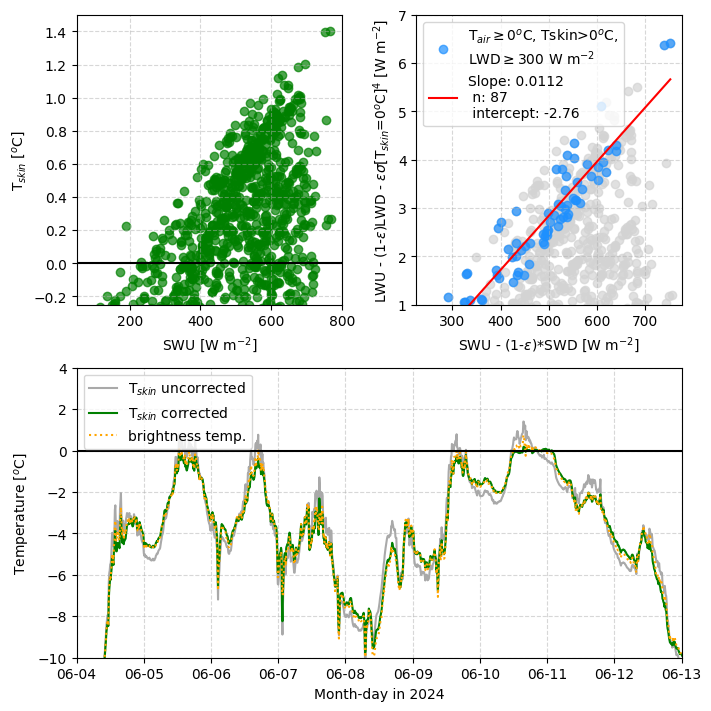

In [114]:
plt.rcParams['font.size'] = 10

fig = plt.figure(constrained_layout=True, figsize=(7,7))
gs = GridSpec(2, 2, figure=fig)

# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2))

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])



warm_idx = np.where( (asfs_data_lev2['temp']>=0)&(asfs_data_lev2['skin_temp_surface']>0) )[0]

# xs = np.ma.masked_outside(asfs_data_lev2['up_short_hemisp'][warm_idx], 0,2000)
xs = np.ma.masked_outside(asfs_data_lev2['up_short_hemisp'], 0,2000)
ys = asfs_data_lev2['skin_temp_surface']#[warm_idx]


# for lower, upper, ax in zip(lwd_bins[:-1], lwd_bins[1:], axs.ravel()):
a_idx = np.where( asfs_data_lev2['down_long_hemisp'][warm_idx]>=300 )[0]
a_xs = xs[warm_idx][a_idx]
a_ys = ys[warm_idx][a_idx]

ax0.scatter(xs, ys, alpha=.7, c='green')
# ax0.scatter(a_xs, a_ys, alpha=.7)

slope, b = np.ma.polyfit(a_xs, a_ys, 1)
lwd_300_intercept = b
lwd_300_slope = slope
# ax0.plot(np.ma.unique(a_xs), np.poly1d(np.ma.polyfit(a_xs, a_ys, 1))(np.ma.unique(a_xs)), c='r', 
#         label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, a_xs.count(), b))

ax0.set_xlabel('SWU [W m$^{-2}$]')
ax0.set_ylabel('T$_{skin}$ [$^o$C]')
ax0.grid(alpha=.5, ls='--')
ax0.axhline(y=0, c='k')
# ax0.legend(loc='upper left')

ax0.set_ylim(-.25,1.5)
ax0.set_xlim(50,800)


ax1.scatter(x_SW_all, delta_LW_all, alpha=.7, c='lightgray')
ax1.scatter(x_SW[a_idx], delta_LW[a_idx], alpha=.7, label='T$_{air}$$\geq$0$^o$C, Tskin>0$^o$C,\nLWD$\geq$300 W m$^{-2}$', c='dodgerblue')
slope, b = np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1)
flx_lw_300_intercept = b
flx_lw_300_slope = slope
ax1.plot(np.ma.unique(x_SW[a_idx]), np.poly1d(np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1))(np.ma.unique(x_SW[a_idx])), c='r', 
        label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, x_SW[a_idx].count(), b))

ax1.set_xlabel('SWU - (1-$\epsilon$)*SWD [W m$^{-2}$]')
ax1.set_ylabel('LWU - (1-$\epsilon$)LWD - $\epsilon$$\sigma$[T$_{skin}$=0$^o$C$]^4$ [W m$^{-2}$]')
ax1.grid(alpha=.5, ls='--')
ax1.axhline(y=0, c='k')
ax1.legend(loc='best')

ax1.set_ylim(1,7)
ax1.set_xlim(225,775)


ax2 = fig.add_subplot(gs[1, :])
ax2.plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='T$_{skin}$ uncorrected', c='darkgrey')
ax2.plot(asfs_data_lev2['dates'], tskin_lw_correction-273.15, label='T$_{skin}$ corrected', c='green')
ax2.plot(asfs_data_lev2['dates'], asfs_data_lev2['brightness_temp_surface'], label='brightness temp.', ls=':', c='orange', lw=1.5)

ax2.set_xlim(datetime.datetime(2024,6,4),datetime.datetime(2024,6,13))
ax2.legend(loc='upper left')
ax2.axhline(y=0, c='k')
ax2.grid(ls='--', alpha=.5)
# plt.ylim(-25,4)
ax2.set_ylim(-10,4)
ax2.set_ylabel('Temperature [$^o$C]')
ax2.xaxis.set_major_formatter(myFmt)
ax2.set_xlabel('Month-day in 2024')

plt.show()

## Back to original plotting...

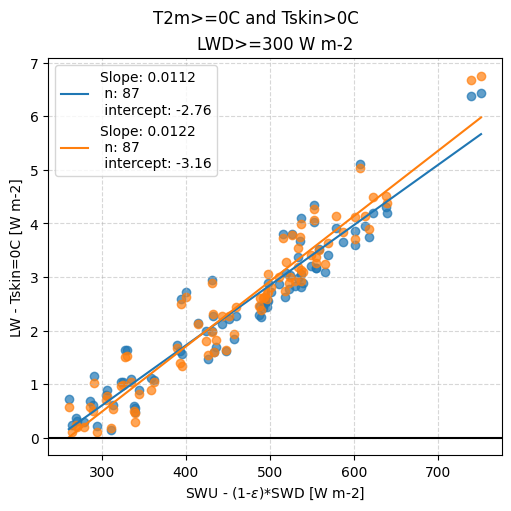

In [43]:
### check potential implicaiton of correcting LWU for intervening atmosphere (w.v. and any other gases, from Chris)
## bias in LW used for Tskin relative to what tskin should be when the surface is melting
delta_LW_aircorr = (asfs_data_lev2['lwu_air_corr']-(1.-epsilon)*asfs_data_lev2['down_long_hemisp'])[warm_idx] - 273.15**4*epsilon*sigma

## complicated x for getting the slope to be what I want
x_SW_aircorr = (asfs_data_lev2['up_short_hemisp'] - (1. - epsilon)*asfs_data_lev2['down_short_hemisp'])[warm_idx]

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5,5))

for xs, ys in zip([x_SW,x_SW_aircorr],[delta_LW, delta_LW_aircorr]):

    ax.scatter(xs[a_idx], ys[a_idx], alpha=.7)
    slope, b = np.ma.polyfit(xs[a_idx], ys[a_idx], 1)
    # flx_lw_300_intercept = b
    # flx_lw_300_slope = slope
    ax.plot(np.ma.unique(xs[a_idx]), np.poly1d(np.ma.polyfit(xs[a_idx], ys[a_idx], 1))(np.ma.unique(xs[a_idx])), #c='r', 
            label='Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(slope, x_SW[a_idx].count(), b))

ax.set_xlabel('SWU - (1-$\epsilon$)*SWD [W m-2]')
ax.set_ylabel('LW - Tskin=0C [W m-2]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=0, c='k')
ax.set_title('LWD>=300 W m-2')
ax.legend(loc='best')


fig.suptitle('T2m>=0C and Tskin>0C')

# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT-regressions_5LWD-bins.png')

plt.show()

In [44]:
def calc_lw_correction(sw, emis, lwc_slope, lwc_intercept):
    ## precision matters!!!!
    ## correction for LW fluxes based on incident SW
    ## LWU uses SWU and LWD using SWD

    # emis = 0.985
    
    correction = sw*lwc_slope + lwc_intercept/emis
    return correction

    

In [45]:
lwu_corr = calc_lw_correction(asfs_data_lev2['up_short_hemisp'], 0.985, flx_lw_300_slope, flx_lw_300_intercept)
# lwu_corr[lwu_corr<0] = 0
lwu_corrected = asfs_data_lev2['up_long_hemisp'] - lwu_corr


lwd_corr = calc_lw_correction(asfs_data_lev2['down_short_hemisp'], 0.985, flx_lw_300_slope, flx_lw_300_intercept)
# lwd_corr[lwd_corr<0] = 0
lwd_corrected = asfs_data_lev2['down_long_hemisp'] - lwd_corr

In [28]:
import csv

In [31]:
with open('Raven_2024_corrected_LW_fluxes.csv', 'w', ) as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    myfile.write("{},{},{}\n".format("Dates", "corrected LWU [W m-2]", "corrected LWD [W m-2]"))
    for item1, item2, item3 in zip(asfs_data_lev2['dates'], lwu_corrected, lwd_corrected):
        wr.writerow([item1, item2, item3])

In [30]:
print(lwu_corrected[:2], lwd_corrected[:2])

[245.65728753329807 245.07773075788091] [227.79867236181002 226.8060027146852]


In [46]:
tskin_lw_correction = calc_skin_temp(lwd_corrected,lwu_corrected,0.985)

In [22]:
## save quick corrected skin temperature for SIMBA comparisons
np.savez_compressed('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz', data=tskin_lw_correction.data, mask=tskin_lw_correction.mask)


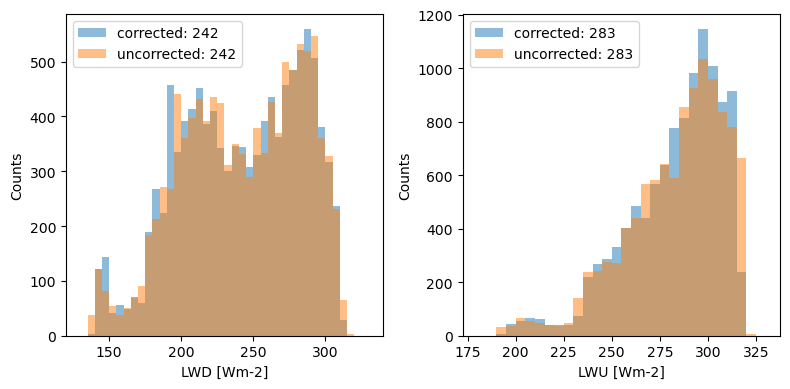

In [27]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

bins = {'down_long_hemisp':np.arange(130,331,5),'up_long_hemisp':np.arange(180,331,5)}
for ax, lwc, lw, label in zip(axs.ravel(),[lwd_corrected, lwu_corrected],['down_long_hemisp','up_long_hemisp'],['LWD [Wm-2]','LWU [Wm-2]']):
    ax.hist(lwc,  label='corrected: {:.0f}'.format(lwc.mean()), alpha=.5, bins=bins[lw])
    ax.hist(asfs_data_lev2[lw],  label='uncorrected: {:.0f}'.format(asfs_data_lev2[lw].mean()), alpha=.5, bins=bins[lw])

    ax.set_xlabel(label)
    ax.set_ylabel('Counts')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

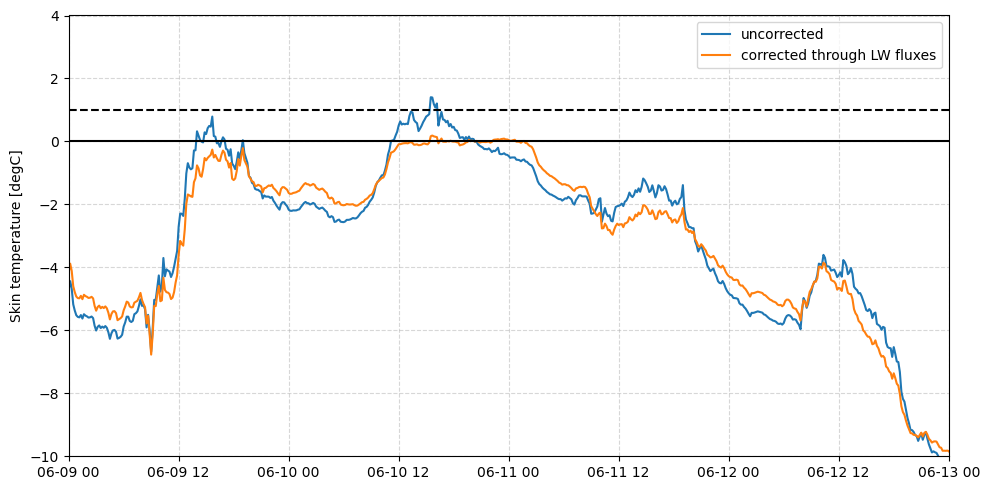

In [28]:
fig, ax = plt.subplots(1, figsize=(10,5))

plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='uncorrected')
plt.plot(asfs_data_lev2['dates'], tskin_lw_correction-273.15, label='corrected through LW fluxes')

plt.xlim(datetime.datetime(2024,6,9),datetime.datetime(2024,6,13))
plt.legend(loc='best')
plt.axhline(y=0, c='k')
plt.axhline(y=1, c='k', ls='--')
plt.grid(ls='--', alpha=.5)
# plt.ylim(-25,4)
plt.ylim(-10,4)
plt.ylabel('Skin temperature [degC]')
plt.tight_layout()
# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_skinT_solar-correction_subset-perc-event.png')

plt.show()

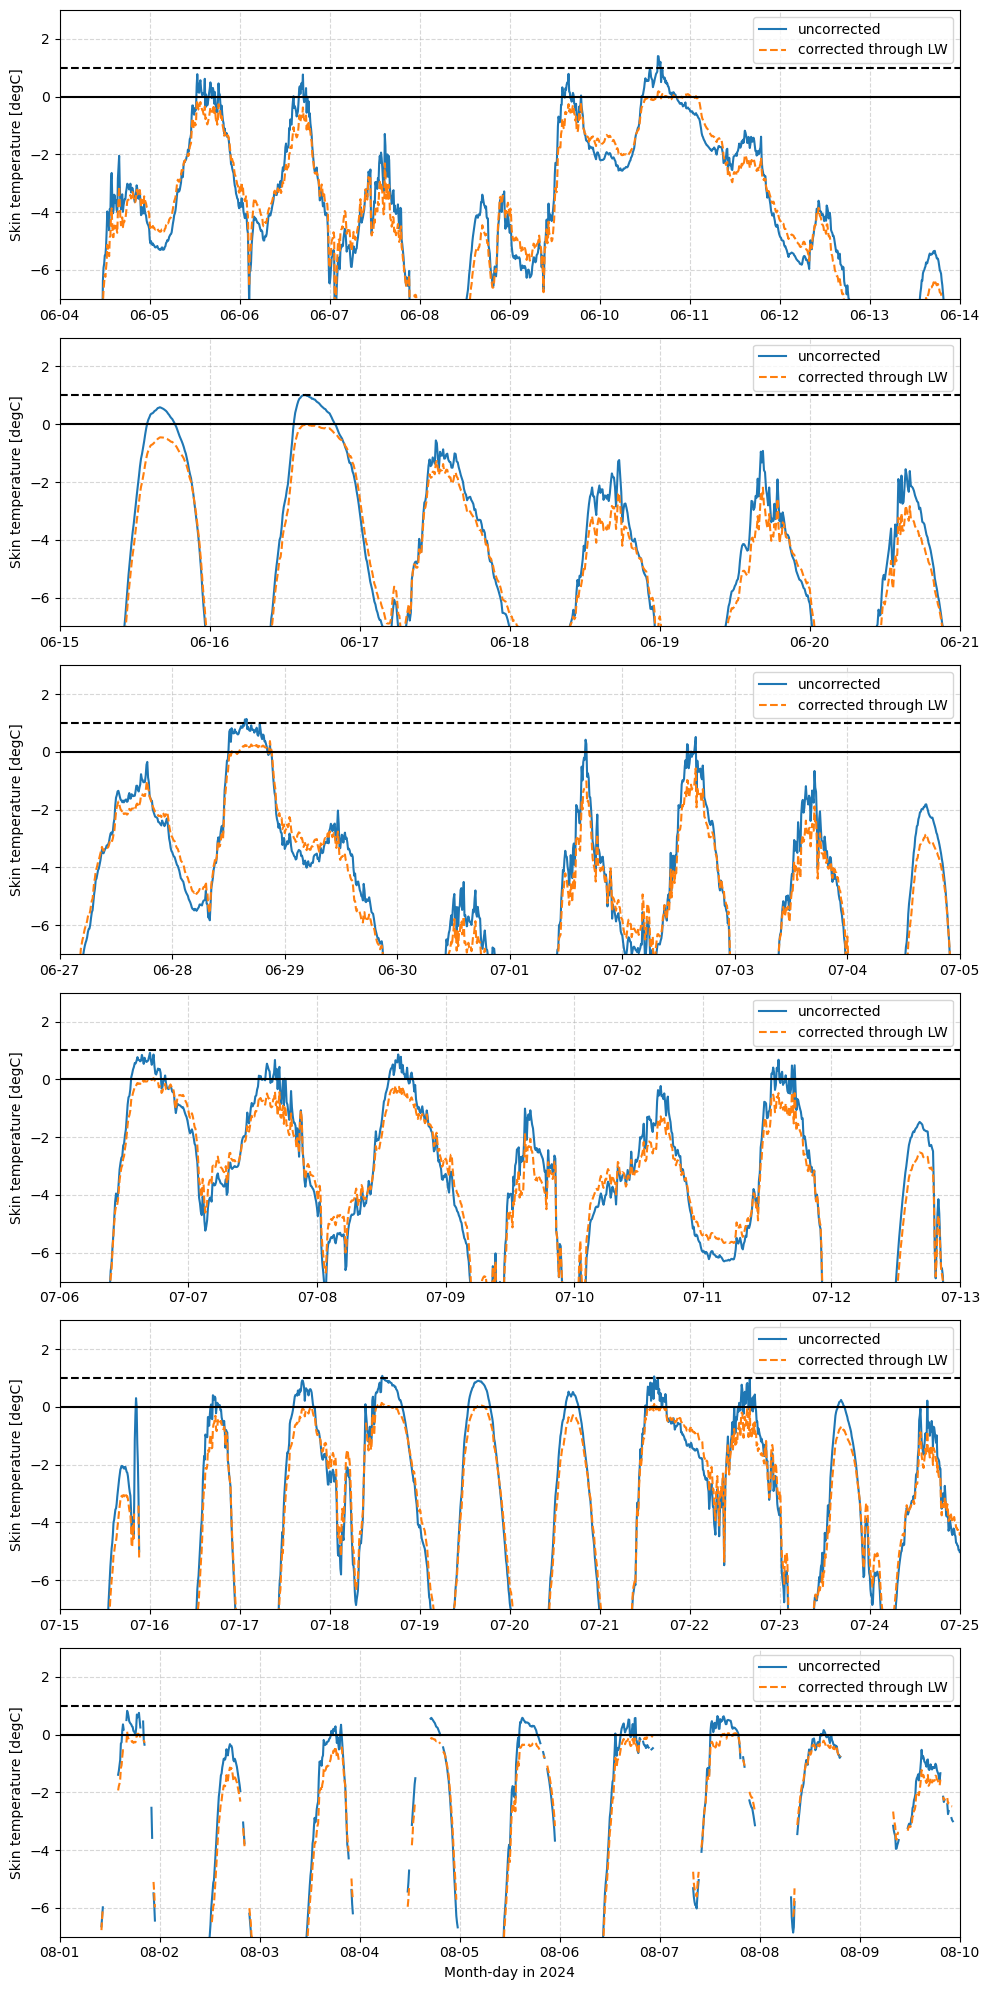

In [29]:
fig, axs = plt.subplots(6, figsize=(10,20))

time_periods = [(datetime.datetime(2024,6,4),datetime.datetime(2024,6,14)),
                (datetime.datetime(2024,6,15),datetime.datetime(2024,6,21)),
                (datetime.datetime(2024,6,27),datetime.datetime(2024,7,5)),
                (datetime.datetime(2024,7,6),datetime.datetime(2024,7,13)),
                (datetime.datetime(2024,7,15),datetime.datetime(2024,7,25)),
                (datetime.datetime(2024,8,1),datetime.datetime(2024,8,10))]

for ax, period in zip(axs.ravel(),time_periods):
    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='uncorrected')
    ax.plot(asfs_data_lev2['dates'], tskin_lw_correction-273.15, ls='--', label='corrected through LW')

    # ax.plot(asfs_data_lev2['dates'], solar_up_correct_tskin_nolwd, ls=':', label='corrected through Tskin')


    
    ax.set_xlim(period[0], period[1])
    ax.set_ylim(-7,3)
    ax.legend(loc='best')
    ax.axhline(y=0, c='k')
    ax.axhline(y=1, c='k', ls='--')
    ax.grid(ls='--', alpha=.5)
    ax.set_ylabel('Skin temperature [degC]')
    ax.xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')
plt.tight_layout()
# plt.savefig('Raven_2024_Tskin-corrected_melting-subsets_SWU-versions_apogee.png', dpi=250)
plt.show()

#### plot LWN distributions w and w/out corrections

In [30]:
lwn_no_corr = asfs_data_lev2['down_long_hemisp'] - asfs_data_lev2['up_long_hemisp']
lwn_both_corr = lwd_corrected - lwu_corrected
lwn_lwu_corr = asfs_data_lev2['down_long_hemisp'] - lwu_corrected

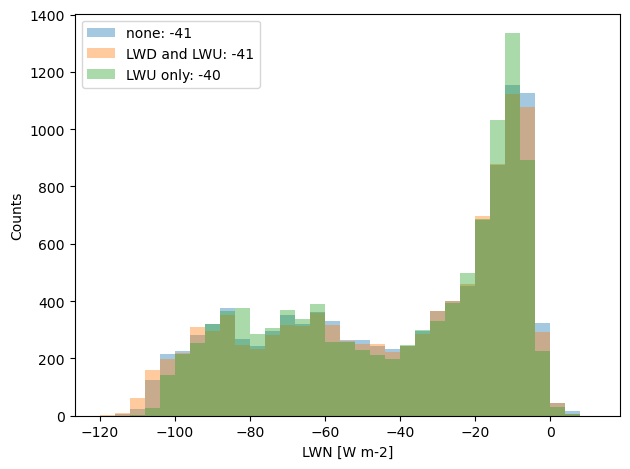

In [31]:
for lwn, label in zip([lwn_no_corr, lwn_both_corr, lwn_lwu_corr],['none','LWD and LWU','LWU only']):
    plt.hist(lwn, label=label+': {:.0f}'.format(lwn.mean()), alpha=.4, bins=np.arange(-120,15,4))

plt.legend(loc='best')
plt.ylabel('Counts')
plt.xlabel('LWN [W m-2]')
plt.tight_layout()
plt.show()

### original correction to skin temperature directly from SWU

In [32]:
def calc_swu_correction_no_lwd(swu, lw_slope, lw_intercept):
    ## precision matters!!!!

    
    correction = swu*lw_slope + lw_intercept
    return correction 

In [33]:
print(lwd_300_intercept, lwd_300_slope)

-0.5974058008131815 0.0024058982938302415


In [34]:
solar_up_correction_nolwd = calc_swu_correction_no_lwd(asfs_data_lev2['up_short_hemisp'], lwd_300_slope, lwd_300_intercept)

solar_up_correction_nolwd[np.where(solar_up_correction_nolwd<0)[0]] = 0.

solar_up_correct_tskin_nolwd = asfs_data_lev2['skin_temp_surface'] - solar_up_correction_nolwd

### apply correction to Tskin

In [35]:

solar_up_correction_nolwd_all = calc_swu_correction_no_lwd(asfs_data_lev2['up_short_hemisp'])


TypeError: calc_swu_correction_no_lwd() missing 2 required positional arguments: 'lw_slope' and 'lw_intercept'

In [36]:

plt.hist(solar_up_correction_nolwd_all, bins=np.arange(-.6,1.6,.05))

plt.axvline(x=0, c='k')
plt.ylabel('Counts')
plt.xlabel('Tskin correction [degC]')
# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_skinT-corrections_SWU-SWD.png')

plt.show()

NameError: name 'solar_up_correction_nolwd_all' is not defined

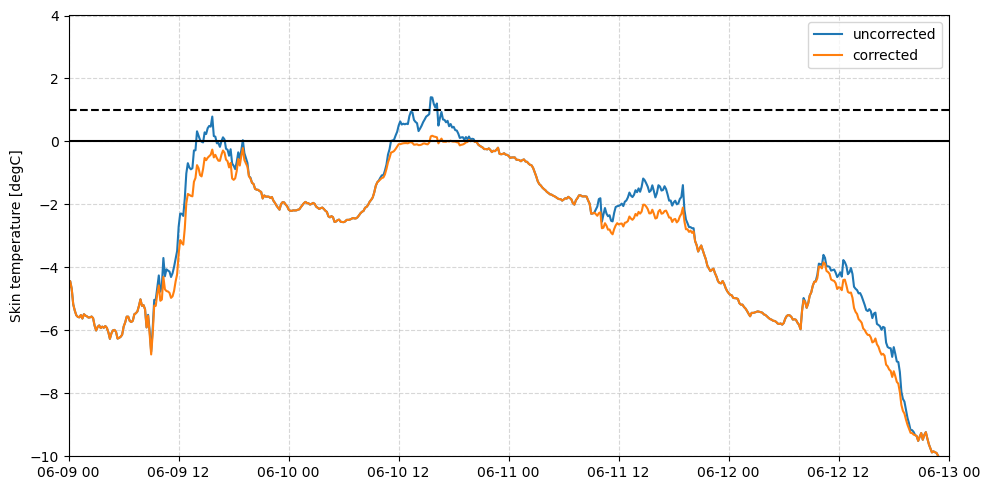

In [37]:
fig, ax = plt.subplots(1, figsize=(10,5))

plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='uncorrected')
plt.plot(asfs_data_lev2['dates'], solar_up_correct_tskin_nolwd, label='corrected')

plt.xlim(datetime.datetime(2024,6,9),datetime.datetime(2024,6,13))
plt.legend(loc='best')
plt.axhline(y=0, c='k')
plt.axhline(y=1, c='k', ls='--')
plt.grid(ls='--', alpha=.5)
# plt.ylim(-25,4)
plt.ylim(-10,4)
plt.ylabel('Skin temperature [degC]')
plt.tight_layout()
# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_skinT_solar-correction_subset-perc-event.png')

plt.show()

In [38]:
## try to make mega plot of multiple times to see if the above example is common or if more work needs to be done

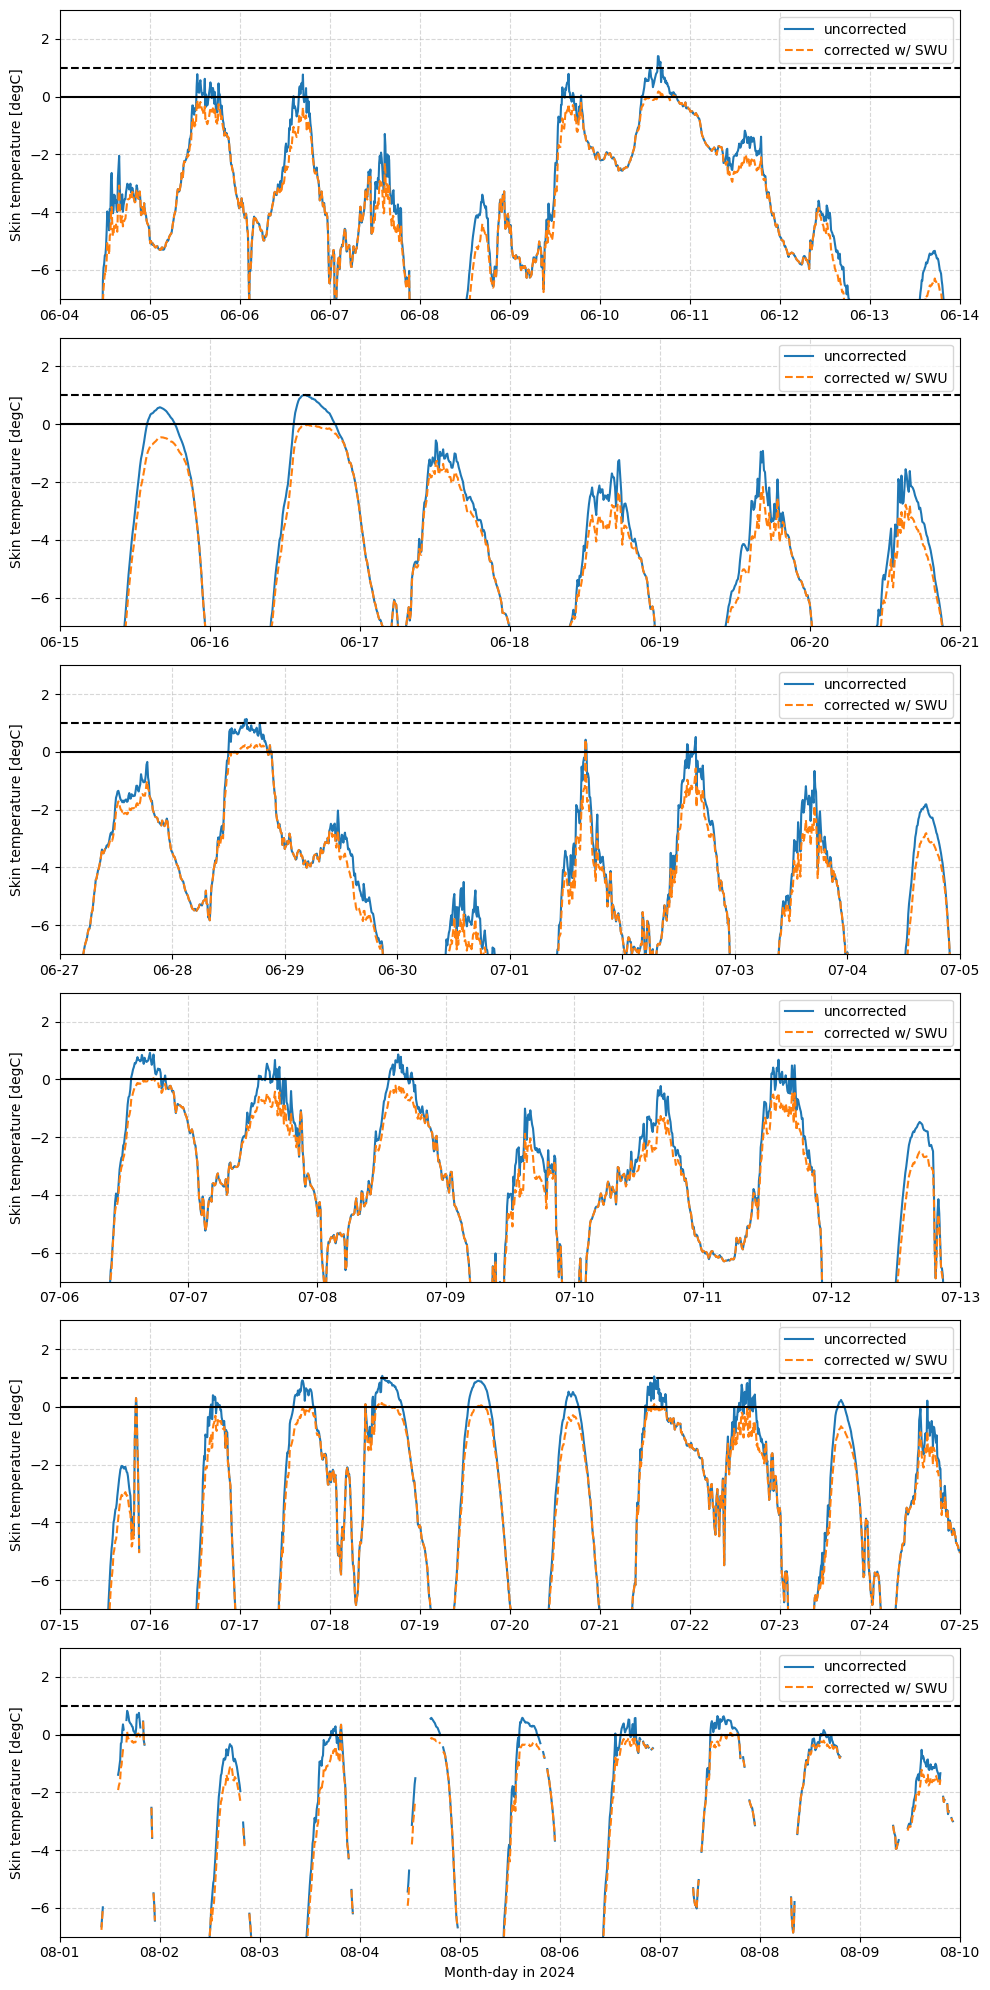

In [39]:
fig, axs = plt.subplots(6, figsize=(10,20))

time_periods = [(datetime.datetime(2024,6,4),datetime.datetime(2024,6,14)),
                (datetime.datetime(2024,6,15),datetime.datetime(2024,6,21)),
                (datetime.datetime(2024,6,27),datetime.datetime(2024,7,5)),
                (datetime.datetime(2024,7,6),datetime.datetime(2024,7,13)),
                (datetime.datetime(2024,7,15),datetime.datetime(2024,7,25)),
                (datetime.datetime(2024,8,1),datetime.datetime(2024,8,10))]

for ax, period in zip(axs.ravel(),time_periods):
    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='uncorrected')
    # ax.plot(asfs_data_lev2['dates'], solar_up_correct_tskin, label='corrected w/ SWU+LWD')
    ax.plot(asfs_data_lev2['dates'], solar_up_correct_tskin_nolwd, ls='--', label='corrected w/ SWU')
    #ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['apogee_targ_T_Avg'], ls=':', label='Apogee')

    ax.set_xlim(period[0], period[1])
    ax.set_ylim(-7,3)
    ax.legend(loc='best')
    ax.axhline(y=0, c='k')
    ax.axhline(y=1, c='k', ls='--')
    ax.grid(ls='--', alpha=.5)
    ax.set_ylabel('Skin temperature [degC]')
    ax.xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')
plt.tight_layout()
# plt.savefig('Raven_2024_Tskin-corrected_melting-subsets_SWU-versions_apogee.png', dpi=250)
plt.show()

#### Try to relate skin temp bias to a LW bias?

In [40]:
epsilon = 0.985
sigma = 5.670374419*(10.**-8)

In [41]:
lwd_bias = (asfs_data_lev2['down_long_hemisp'] - (1.-epsilon)*asfs_data_lev2['up_long_hemisp'])/( (solar_up_correct_tskin_nolwd+273.15)**4*epsilon*sigma )

## testing the impact of varying emissivity

DCS doesn't think snow emissivity for broadband will vary much (nothing is included in Icepack)

In [42]:
emis_savepath = '/home/asledd/ICECAPS/temp_bias_figures/emissivity/'

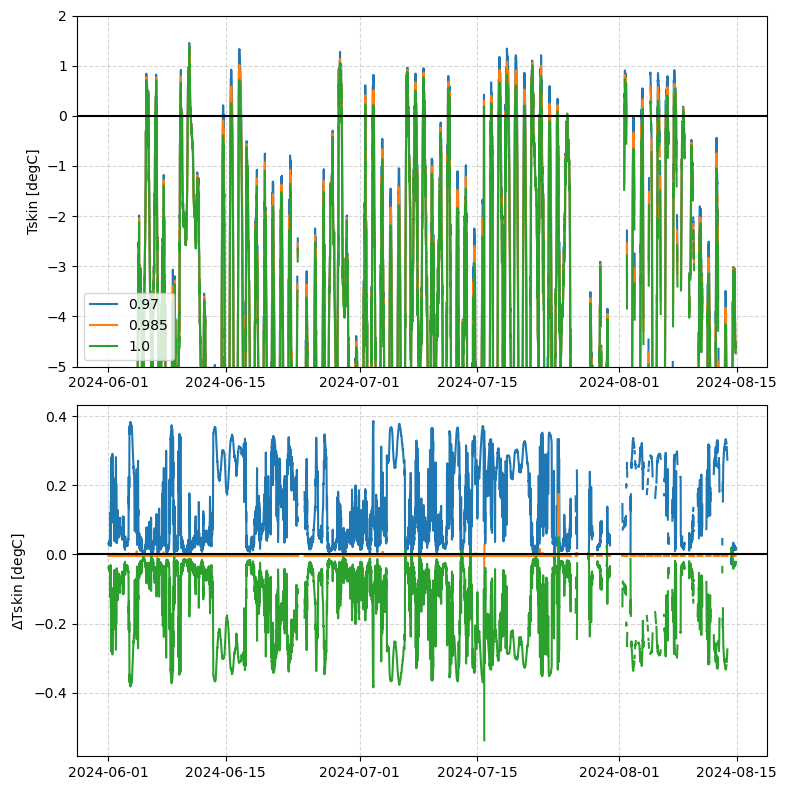

In [52]:
fig, axs = plt.subplots(2, figsize=(8,8))


for em in [.97, 0.985, 1.]:
    ts_em = calc_skin_temp(asfs_data_lev2['down_long_hemisp'],asfs_data_lev2['up_long_hemisp'],em)-273.15
    axs[0].plot(asfs_data_lev2['dates'], ts_em, label=em)

    axs[1].plot(asfs_data_lev2['dates'], ts_em-asfs_data_lev2['skin_temp_surface'], label=em)


axs[0].set_ylim(-5,2)

axs[0].legend(loc='lower left')
axs[0].set_ylabel('Tskin [degC]')
axs[1].set_ylabel('$\Delta$Tskin [degC]')
for ax in axs.ravel():
    ax.axhline(y=0, c='k')
    ax.grid(alpha=.5, ls='--')
plt.tight_layout()
# plt.savefig(emis_savepath+'Raven_2024_emissivity-uncertainty_Tskin.png', dpi=250)
plt.show()

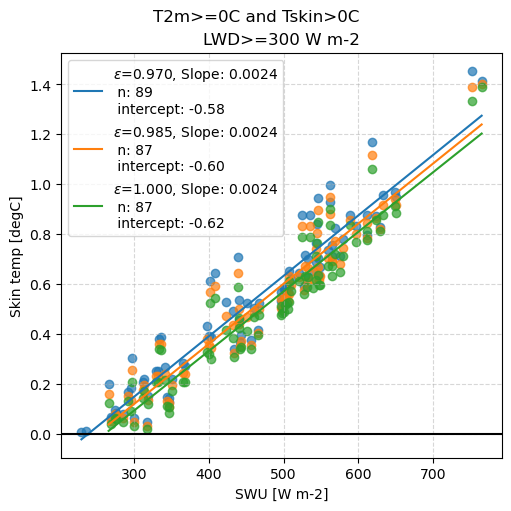

In [46]:
sigma = 5.670374419*(10.**-8)


fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5,5))

for em in [.97, 0.985, 1.]:
    ts_em = calc_skin_temp(asfs_data_lev2['down_long_hemisp'],asfs_data_lev2['up_long_hemisp'],em)-273.15
    warm_idx = np.where( (asfs_data_lev2['temp']>=0)&(ts_em>0) )[0]

    xs = np.ma.masked_outside(asfs_data_lev2['up_short_hemisp'][warm_idx], 0,2000)
    ys = ts_em[warm_idx]
        
    
    # for lower, upper, ax in zip(lwd_bins[:-1], lwd_bins[1:], axs.ravel()):
    a_idx = np.where( asfs_data_lev2['down_long_hemisp'][warm_idx]>=300 )[0]
    a_xs = xs[a_idx]
    a_ys = ys[a_idx]
    
    ax.scatter(a_xs, a_ys, alpha=.7)
    slope, b = np.ma.polyfit(a_xs, a_ys, 1)
    lwd_300_intercept = b
    lwd_300_slope = slope
    ax.plot(np.ma.unique(a_xs), np.poly1d(np.ma.polyfit(a_xs, a_ys, 1))(np.ma.unique(a_xs)), 
            label='$\epsilon$={:.3f}, Slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(em, slope, a_xs.count(), b))

ax.set_xlabel('SWU [W m-2]')
ax.set_ylabel('Skin temp [degC]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=0, c='k')
ax.set_title('LWD>=300 W m-2')
ax.legend(loc='best')


fig.suptitle('T2m>=0C and Tskin>0C')

# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT-regressions_5LWD-bins.png')
# plt.savefig(emis_savepath+'Raven_2024_emissivity-uncertainty_Tskin-v-SWU.png')

plt.show()

### go through LW correction using different emissivities: what are the resulting Tskin tempearture time series and LW distributions?


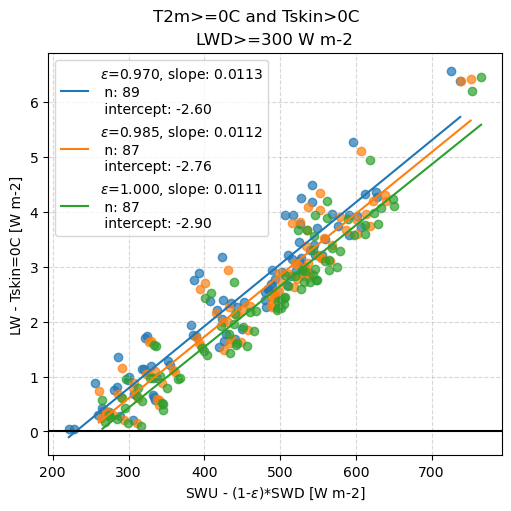

In [51]:
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5,5))

em_statistics = {em:{} for em in [.97, 0.985, 1.]}



for em in [.97, 0.985, 1.]:
    ts_em = calc_skin_temp(asfs_data_lev2['down_long_hemisp'],asfs_data_lev2['up_long_hemisp'],em)
    warm_idx = np.where( (asfs_data_lev2['temp']>=0)&(ts_em>273.15) )[0]
    a_idx = np.where( (asfs_data_lev2['down_long_hemisp'][warm_idx])>=300 )[0]
    
    ## bias in LW used for Tskin relative to what tskin should be when the surface is melting
    delta_LW = (asfs_data_lev2['up_long_hemisp']-(1.-em)*asfs_data_lev2['down_long_hemisp'])[warm_idx] - 273.15**4*em*sigma
    
    ## complicated x for getting the slope to be what I want
    x_SW = (asfs_data_lev2['up_short_hemisp'] - (1. - em)*asfs_data_lev2['down_short_hemisp'])[warm_idx]

    ax.scatter(x_SW[a_idx], delta_LW[a_idx], alpha=.7)
    slope, b = np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1)
    em_statistics[em]['intercept'] = b
    em_statistics[em]['slope'] = slope
    ax.plot(np.ma.unique(x_SW[a_idx]), np.poly1d(np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1))(np.ma.unique(x_SW[a_idx])),
            label='$\epsilon$={:.3f}, slope: {:.4f}\n n: {:.0f}\n intercept: {:.2f}'.format(em, slope, x_SW[a_idx].count(), b))

ax.set_xlabel('SWU - (1-$\epsilon$)*SWD [W m-2]')
ax.set_ylabel('LW - Tskin=0C [W m-2]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=0, c='k')
ax.set_title('LWD>=300 W m-2')
ax.legend(loc='best')


fig.suptitle('T2m>=0C and Tskin>0C')

# plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_SWU-skinT-regressions_5LWD-bins.png')
# plt.savefig(emis_savepath+'Raven_2024_emissivity-uncertainty_SWU-LWU_bias.png', dpi=250)

plt.show()

0.97 {'intercept': -2.600995636473241, 'slope': 0.011292659857585602}
0.985 {'intercept': -2.7604022047050636, 'slope': 0.011211106287105392}
1.0 {'intercept': -2.8956442706602883, 'slope': 0.011086302574944541}


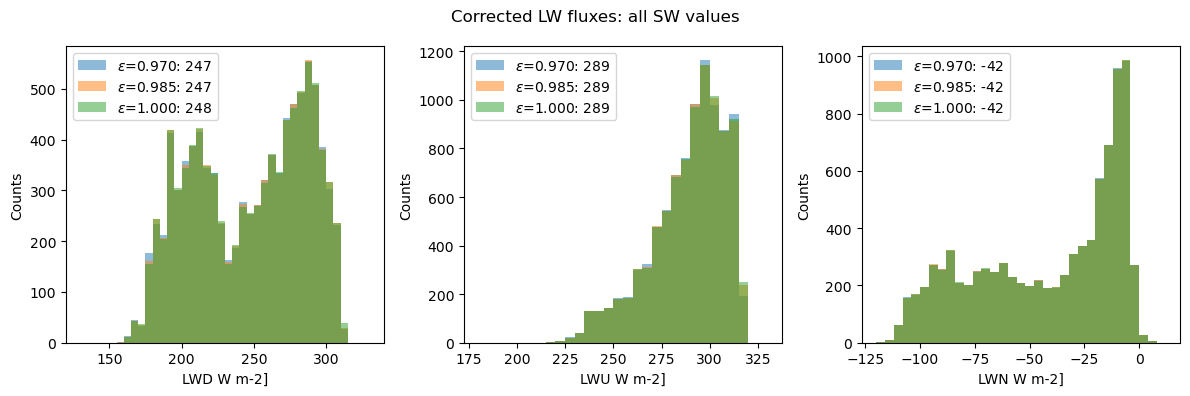

In [48]:
# Now apply corrections to LW
fig, axs = plt.subplots(1,3, figsize=(12,4))

bins = {'LWD':np.arange(130,331,5),'LWU':np.arange(180,331,5), 'LWN':np.arange(-120,15,4)}
corrected_lw = {em:{} for em in [.97, 0.985, 1.]}

for em in em_statistics:
    print(em, em_statistics[em])
    lwu_corr = calc_lw_correction(asfs_data_lev2['up_short_hemisp'], em, em_statistics[em]['slope'], em_statistics[em]['intercept'])
    # lwu_corr[lwu_corr<0] = 0
    lwu_corrected = asfs_data_lev2['up_long_hemisp'] - lwu_corr
    
    
    lwd_corr = calc_lw_correction(asfs_data_lev2['down_short_hemisp'], em, em_statistics[em]['slope'], em_statistics[em]['intercept'])
    # lwd_corr[lwd_corr<0] = 0
    lwd_corrected = asfs_data_lev2['down_long_hemisp'] - lwd_corr

    lwn = lwd_corrected-lwu_corrected

    # save for seeing impact on Tskin
    corrected_lw[em]['LWD'] = lwd_corrected
    corrected_lw[em]['LWU'] = lwu_corrected

    for ax, lwc, label in zip(axs.ravel(),[lwd_corrected, lwu_corrected, lwn],['LWD','LWU', 'LWN']):
        ax.hist(lwc,  label='$\epsilon$={:.3f}: {:.0f}'.format(em, lwc.mean()), alpha=.5, bins=bins[label])
        # ax.hist(asfs_data_lev2[lw],  label='$\epsilon$={:.3f}: {:.0f}'.format(asfs_data_lev2[lw].mean()), alpha=.5, bins=bins[lw])
    
        ax.set_xlabel(label+' W m-2]')
        ax.set_ylabel('Counts')
        ax.legend(loc='best')

fig.suptitle('Corrected LW fluxes: all SW values')
plt.tight_layout()
# plt.savefig(emis_savepath+'Raven_2024_emissivity-uncertainty_LW-distributions.png')

plt.show()

0.97 {'intercept': -2.600995636473241, 'slope': 0.011292659857585602}
0.985 {'intercept': -2.7604022047050636, 'slope': 0.011211106287105392}
1.0 {'intercept': -2.8956442706602883, 'slope': 0.011086302574944541}
0.97 {'intercept': -2.600995636473241, 'slope': 0.011292659857585602}
0.985 {'intercept': -2.7604022047050636, 'slope': 0.011211106287105392}
1.0 {'intercept': -2.8956442706602883, 'slope': 0.011086302574944541}


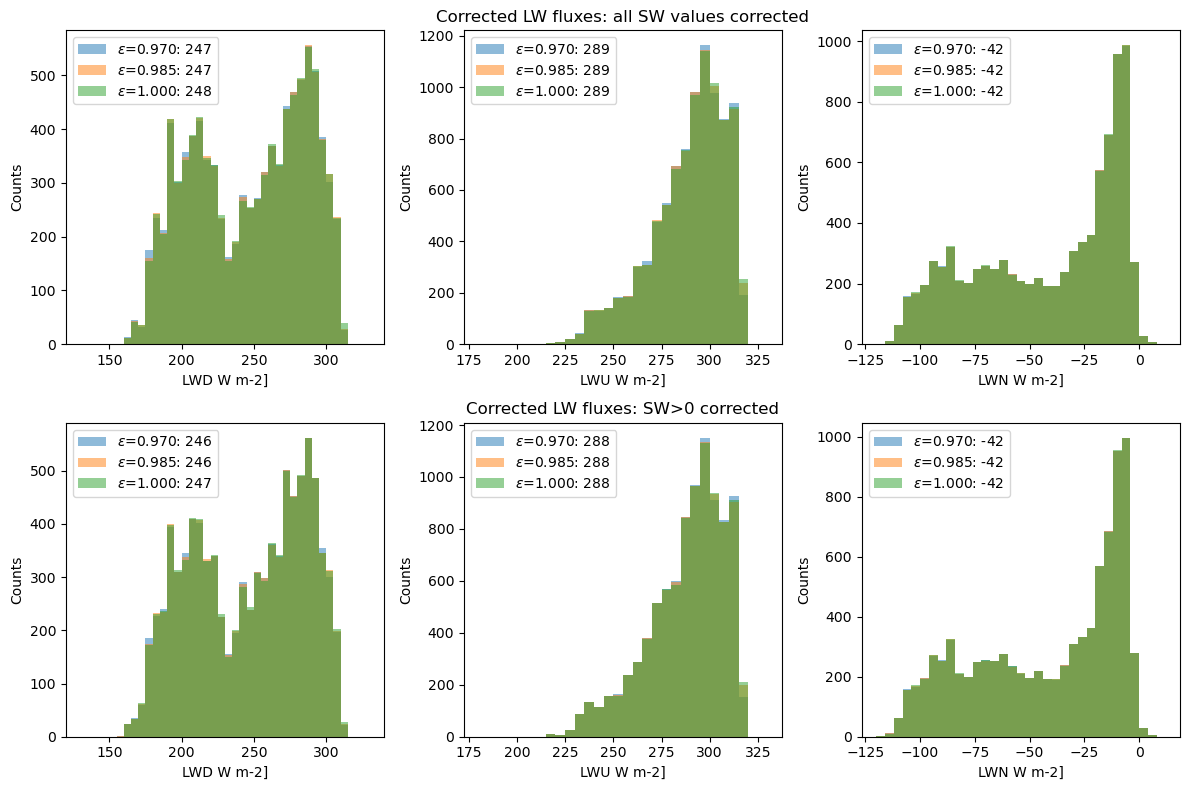

In [55]:
# Now apply corrections to LW
fig, axs = plt.subplots(2,3, figsize=(12,8))

bins = {'LWD':np.arange(130,331,5),'LWU':np.arange(180,331,5), 'LWN':np.arange(-120,15,4)}
corrected_lw = {em:{} for em in [.97, 0.985, 1.]}
corrected_lw_allsw = {em:{} for em in [.97, 0.985, 1.]}

for j, title in enumerate(['all SW values corrected', 'SW>0 corrected']):
    for em in em_statistics:
        print(em, em_statistics[em])
        lwu_corr = calc_lw_correction(asfs_data_lev2['up_short_hemisp'], em, em_statistics[em]['slope'], em_statistics[em]['intercept'])
        if j==1:
            lwu_corr[lwu_corr<0] = 0
        lwu_corrected = asfs_data_lev2['up_long_hemisp'] - lwu_corr
        
        
        lwd_corr = calc_lw_correction(asfs_data_lev2['down_short_hemisp'], em, em_statistics[em]['slope'], em_statistics[em]['intercept'])
        if j==1:
            lwd_corr[lwd_corr<0] = 0
        lwd_corrected = asfs_data_lev2['down_long_hemisp'] - lwd_corr
    
        lwn = lwd_corrected-lwu_corrected
    
        # save for seeing impact on Tskin
        if j==1:
            corrected_lw[em]['LWD'] = lwd_corrected
            corrected_lw[em]['LWU'] = lwu_corrected
        elif j==0:
            corrected_lw_allsw[em]['LWD'] = lwd_corrected
            corrected_lw_allsw[em]['LWU'] = lwu_corrected
        for i, (lwc, label) in enumerate(zip([lwd_corrected, lwu_corrected, lwn],['LWD','LWU', 'LWN'])):
            axs[j][i].hist(lwc,  label='$\epsilon$={:.3f}: {:.0f}'.format(em, lwc.mean()), alpha=.5, bins=bins[label])
            # ax.hist(asfs_data_lev2[lw],  label='$\epsilon$={:.3f}: {:.0f}'.format(asfs_data_lev2[lw].mean()), alpha=.5, bins=bins[lw])
        
            axs[j][i].set_xlabel(label+' W m-2]')
            axs[j][i].set_ylabel('Counts')
            axs[j][i].legend(loc='best')
    
    axs[j][1].set_title('Corrected LW fluxes: '+title)
plt.tight_layout()
# plt.savefig(emis_savepath+'Raven_2024_emissivity-uncertainty_LW-distributions_all-someSW.png', dpi=250)

plt.show()

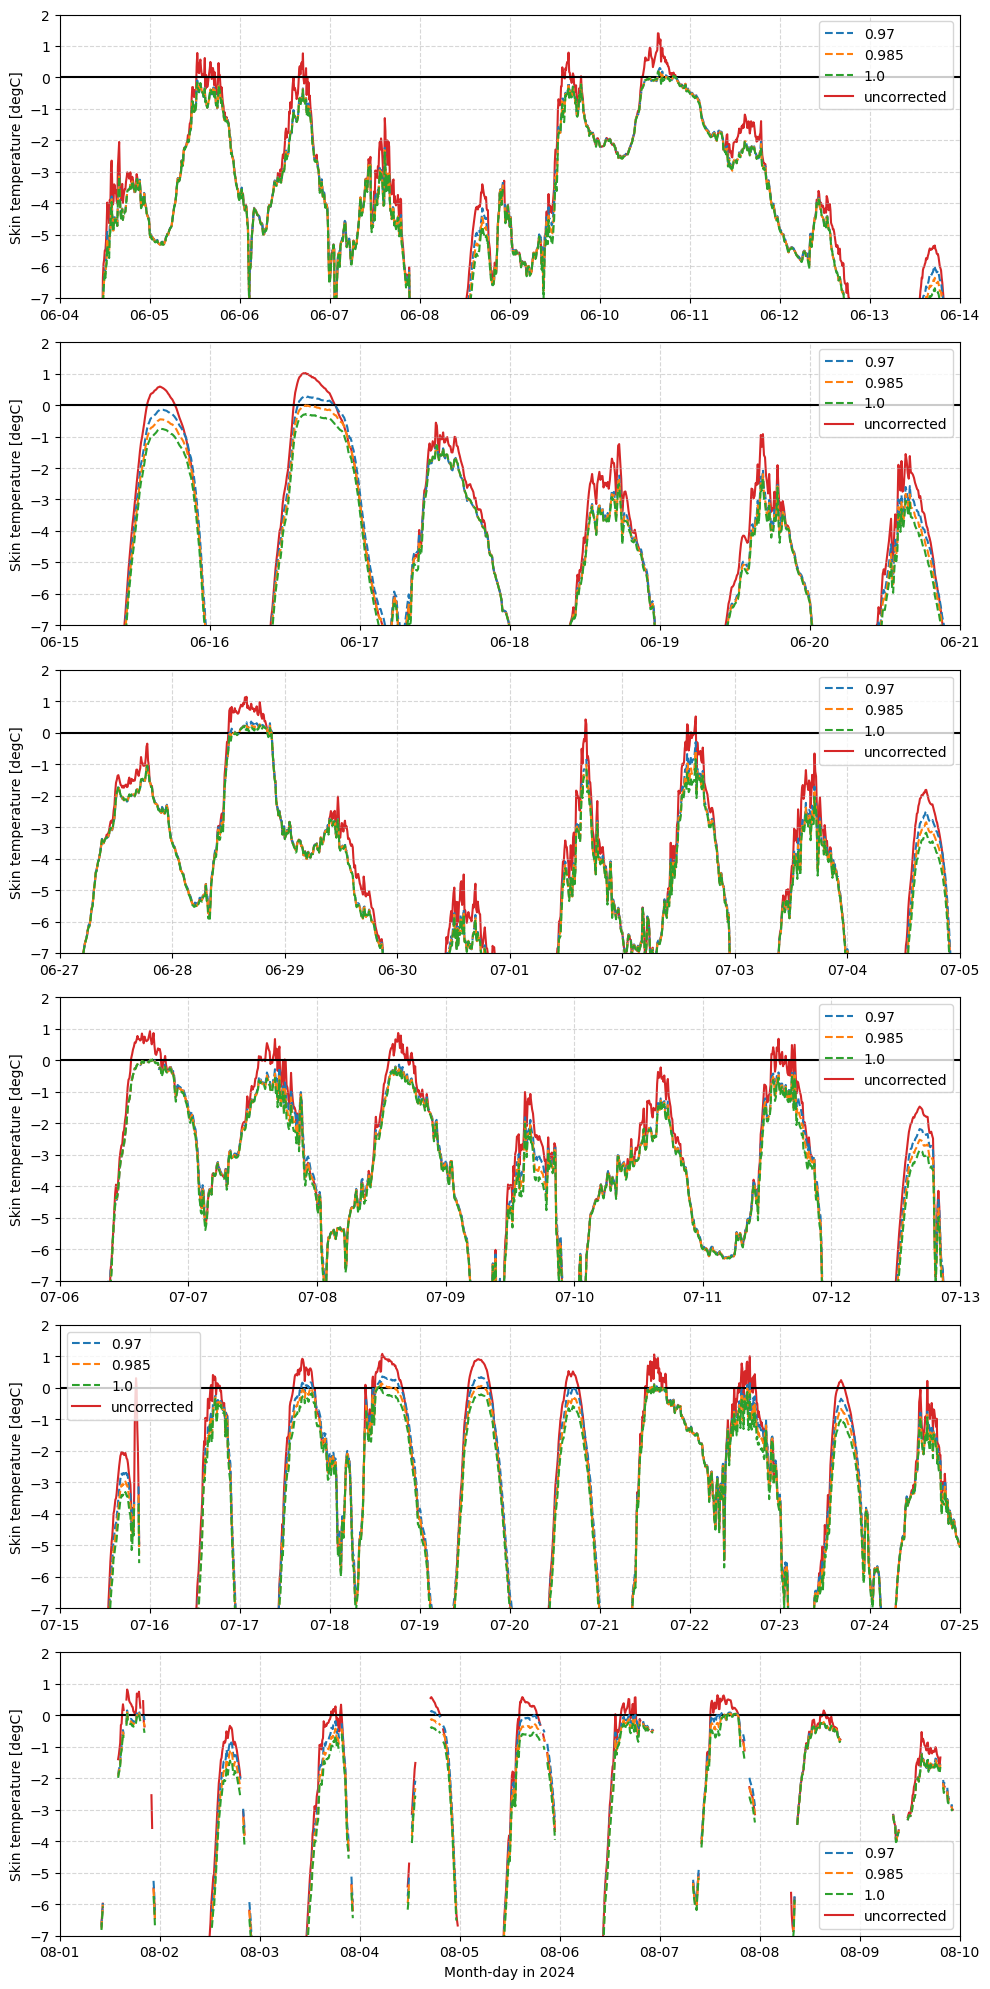

In [66]:
fig, axs = plt.subplots(6, figsize=(10,20))

time_periods = [(datetime.datetime(2024,6,4),datetime.datetime(2024,6,14)),
                (datetime.datetime(2024,6,15),datetime.datetime(2024,6,21)),
                (datetime.datetime(2024,6,27),datetime.datetime(2024,7,5)),
                (datetime.datetime(2024,7,6),datetime.datetime(2024,7,13)),
                (datetime.datetime(2024,7,15),datetime.datetime(2024,7,25)),
                (datetime.datetime(2024,8,1),datetime.datetime(2024,8,10))]

for em in corrected_lw:
    ts_em_corrected = calc_skin_temp(corrected_lw[em]['LWD'],corrected_lw[em]['LWU'],em)


    for ax, period in zip(axs.ravel(),time_periods):
        
        ax.plot(asfs_data_lev2['dates'], ts_em_corrected-273.15, ls='--', label=em, zorder=10)



for ax, period in zip(axs.ravel(),time_periods):
    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp_surface'], label='uncorrected', zorder=0)
    ax.set_xlim(period[0], period[1])
    ax.set_ylim(-7,2)
    ax.legend(loc='best')
    ax.axhline(y=0, c='k')
    # ax.axhline(y=1, c='k', ls='--')
    ax.grid(ls='--', alpha=.5)
    ax.set_ylabel('Skin temperature [degC]')
    ax.xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')
plt.tight_layout()
# plt.savefig('Raven_2024_Tskin-corrected_melting-subsets_SWU-versions_apogee.png', dpi=250)
# plt.savefig(emis_savepath+'Raven_2024_emissivity-uncertainty_Tskin-corrections-through-LW.png', dpi=250)

plt.show()

### After meeting w/ Matt+Michael on 1/8/25: comparisons to IRT (brightness temperature) w/ level 2 data

Stick w/ original method of emissivity=0.985; assume linear using LWD and temperature thresholds; only apply positive corrections

Compare w/ IRT (brightness temperature)

In [69]:
base = datetime.datetime(2024,6,1)

time_periods = [base + datetime.timedelta(days=x) for x in range(0,6*12,6)]
print(len(time_periods), time_periods[-1])

12 2024-08-06 00:00:00


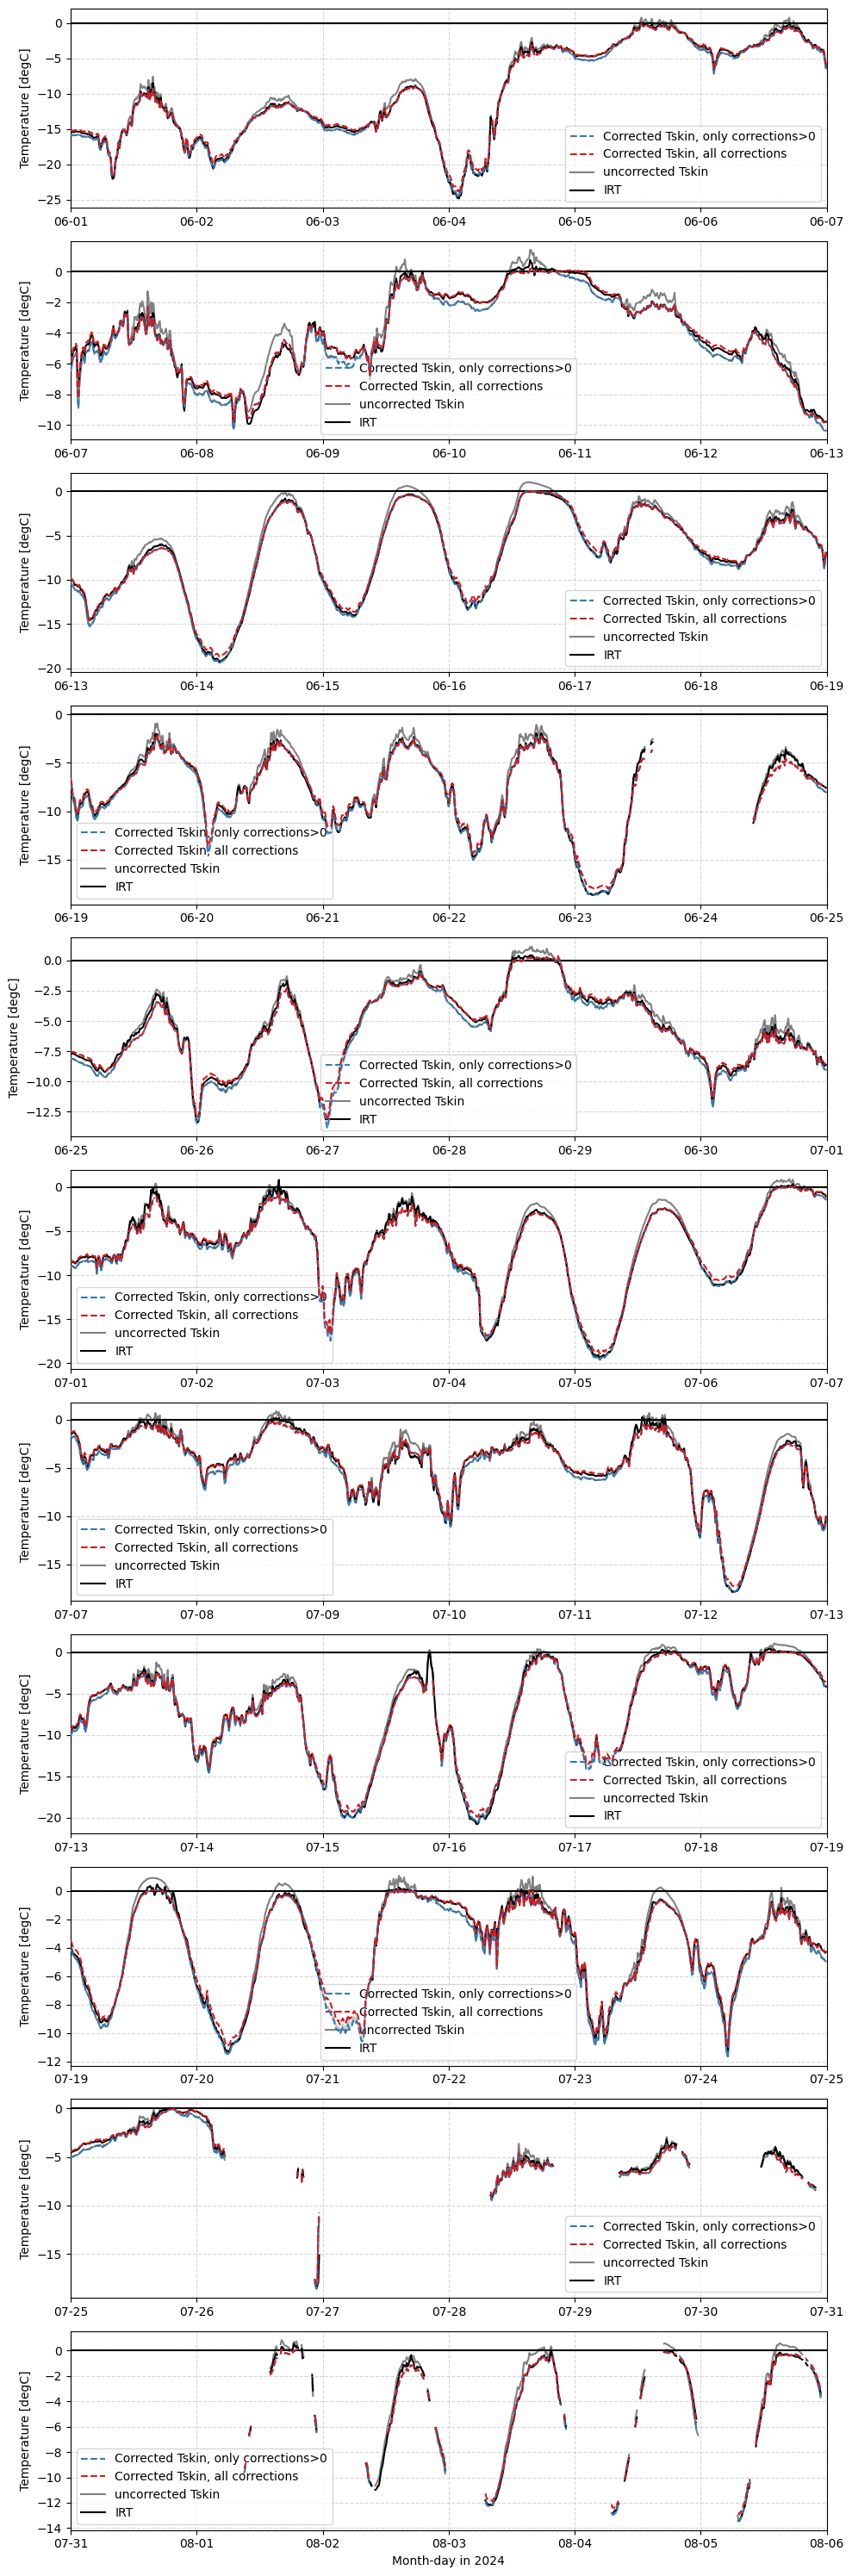

In [129]:
fig, axs = plt.subplots(11, figsize=(10,30))

# original time segments that were focused on melt times
# time_periods = [(datetime.datetime(2024,6,4),datetime.datetime(2024,6,14)),
#                 (datetime.datetime(2024,6,15),datetime.datetime(2024,6,21)),
#                 (datetime.datetime(2024,6,27),datetime.datetime(2024,7,5)),
#                 (datetime.datetime(2024,7,6),datetime.datetime(2024,7,13)),
#                 (datetime.datetime(2024,7,15),datetime.datetime(2024,7,25)),
#                 (datetime.datetime(2024,8,1),datetime.datetime(2024,8,10))]

base = datetime.datetime(2024,6,1)

time_periods = [base + datetime.timedelta(days=x) for x in range(0,6*12,6)]

lower_ylim = [-25, -15, -18, -18, -20, -15]

em = 0.985
for lw_dic, label, c in zip([corrected_lw, corrected_lw_allsw],['only corrections>0', 'all corrections'],['#2C7BB6','#D7191C']):
    ts_em_corrected = calc_skin_temp(lw_dic[em]['LWD'],lw_dic[em]['LWU'],em)
    
    for ax, period0, period1 in zip(axs.ravel(),time_periods[:-1], time_periods[1:]):
        period_idx = np.where((asfs_data_lev2['dates']>=period0)&(asfs_data_lev2['dates']<period1))[0]
        ax.plot(asfs_data_lev2['dates'][period_idx], ts_em_corrected[period_idx]-273.15, ls='--', label='Corrected Tskin, '+label, 
                c=c, zorder=10)



# for ax, period, yl in zip(axs.ravel(),time_periods, lower_ylim):
for ax, period0, period1 in zip(axs.ravel(), time_periods[:-1], time_periods[1:]):

    period_idx = np.where((asfs_data_lev2['dates']>=period0)&(asfs_data_lev2['dates']<period1))[0]
    ax.plot(asfs_data_lev2['dates'][period_idx], asfs_data_lev2['skin_temp_surface'][period_idx], label='uncorrected Tskin', zorder=0, c='gray')
    ax.plot(asfs_data_lev2['dates'][period_idx], asfs_data_lev2['brightness_temp_surface'][period_idx], label='IRT', zorder=0, c='k')

    ax.set_xlim(period0, period1)
    # ax.set_ylim(-7,2)
    # ax.set_ylim(yl, 2)
    ax.legend(loc='best')
    ax.axhline(y=0, c='k')
    # ax.axhline(y=1, c='k', ls='--')
    ax.grid(ls='--', alpha=.5)
    ax.set_ylabel('Temperature [degC]')
    ax.xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')
plt.tight_layout()
# plt.savefig('Raven_2024_Tskin-corrected_melting-subsets_SWU-versions_apogee.png', dpi=250)
plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_Tskin-corrections_all-onlypos_IRT_timeseries.png', dpi=250)

plt.show()

In [74]:
ts_correct_all = calc_skin_temp(corrected_lw_allsw[em]['LWD'],corrected_lw_allsw[em]['LWU'],em)-273.15 ## bias correction for all times
ts_correct_pos = calc_skin_temp(corrected_lw[em]['LWD'],corrected_lw[em]['LWU'],em)-273.15 ## only correction for positive bias

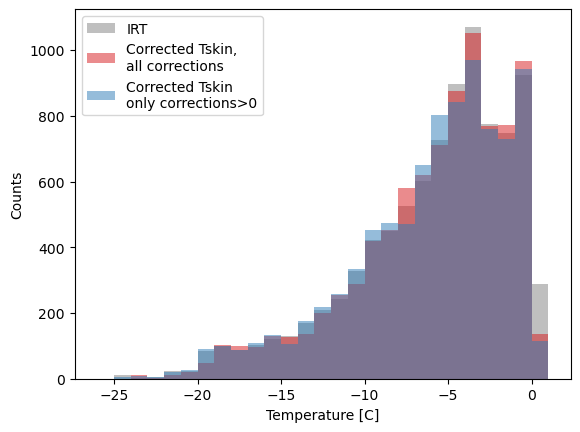

In [126]:
labels = ['IRT', 'Corrected Tskin,\nall corrections', 'Corrected Tskin\nonly corrections>0']
colors=['gray', '#D7191C','#2C7BB6']

for i, temp in enumerate([asfs_data_lev2['brightness_temp_surface'], ts_correct_all, ts_correct_pos]):
    plt.hist(temp[~temp.mask], alpha=.5, label=labels[i], bins = np.arange(-26,2,1), color=colors[i])

plt.xlabel('Temperature [C]')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_Tskin-corrections_all-onlypos_IRT_distributions.png', dpi=250)

plt.show()

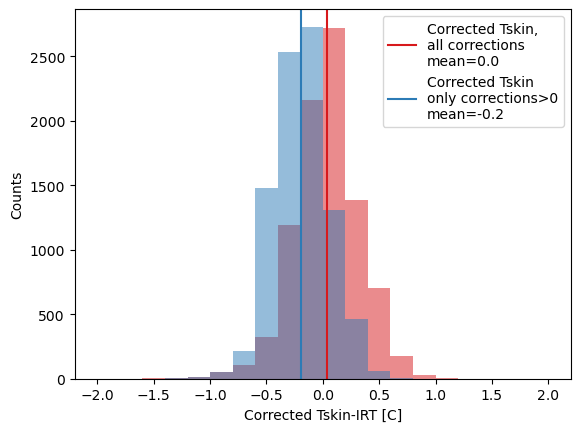

In [127]:

for i, temp in enumerate([ts_correct_all, ts_correct_pos]):
    temp_diff = temp-asfs_data_lev2['brightness_temp_surface']
    plt.hist(temp_diff[~temp_diff.mask], alpha=.5, bins = np.arange(-2,2.1,.2), color=colors[i+1])
    plt.axvline(x=temp_diff.mean(), label=labels[i+1]+'\nmean={:.1f}'.format(temp_diff.mean()), c=colors[i+1])
    
plt.xlabel('Corrected Tskin-IRT [C]')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_Tskin-corrections_IRT-diff.png', dpi=250)

plt.show()

In [97]:
irt = asfs_data_lev2['brightness_temp_surface']
ts_correct_all_diff = ts_correct_all - irt
ts_correct_pos_diff = ts_correct_pos - irt

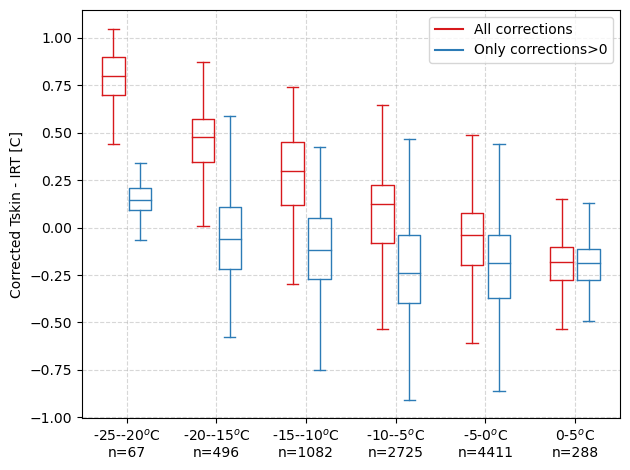

In [128]:
temp_bins = np.arange(-25,6,5)

all_corrections = []
positive_corrections = []

temp_diff_labels = []

for t0, t1 in zip(temp_bins[:-1],temp_bins[1:]):
    bin_idx = np.where((irt>=t0)&(irt<t1))[0]
    temp_diff_labels.append('{:.0f}-{:.0f}$^o$C\nn={:.0f}'.format(t0,t1, len(bin_idx)))
    
    for lst, data in zip([all_corrections, positive_corrections], [ts_correct_all_diff, ts_correct_pos_diff]):
        lst.append(data[bin_idx]) 

bpl = plt.boxplot(all_corrections, positions=np.array(range(len(all_corrections)))*2.0-0.3, sym='', widths=0.5)
bpr = plt.boxplot(positive_corrections, positions=np.array(range(len(positive_corrections)))*2.0+0.3, sym='', widths=0.5)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='All corrections')
plt.plot([], c='#2C7BB6', label='Only corrections>0')
plt.legend()
plt.grid(alpha=.5, ls='--')
plt.xticks(range(0, len(temp_diff_labels) * 2, 2), temp_diff_labels)
plt.xlim(-1, len(temp_diff_labels)*2-1)
# plt.ylim(0, 8)
plt.ylabel('Corrected Tskin - IRT [C]')
plt.tight_layout()
plt.savefig('/home/asledd/ICECAPS/temp_bias_figures/Raven_2024_Tskin-corrections_IRT-diff_temp-bins.png', dpi=250)

plt.show()

## Error estimation!!!

In [25]:
def power_rule(lwu, lwd):
    sig = 5.670374419*(10.**-8)
    eps = 0.985
    
    return .25*( (lwu - (1.-eps)*lwd)/(eps*sig) )**-.75

In [26]:
def calc_dLWU(lwu, lwd):
    sig = 5.670374419*(10.**-8)
    eps = 0.985
    return power_rule(lwu, lwd)/(eps*sig)

In [27]:
def calc_dLWD(lwu, lwd):
    sig = 5.670374419*(10.**-8)
    eps = 0.985
    return power_rule(lwu, lwd)*(1.-eps)/(eps*sig)

In [28]:
def calc_dEPS(lwu, lwd):
    sig = 5.670374419*(10.**-8)
    eps = 0.985

    quotient = (eps*sig*lwd - sigma*(lwu-(1-eps)*lwd))/(eps*sig)**2
    return power_rule(lwu, lwd)*quotient

In [29]:
def calc_stderr(lwu, lwd, s_lwu=1.0, s_lwd=2.6, s_eps=0.015):
    df_dlwu = calc_dLWU(lwu, lwd)
    df_dlwd = calc_dLWD(lwu, lwd)
    df_deps = calc_dEPS(lwu, lwd)

    # s_lwu = 1.0 # W m-2
    # s_lwd = 2.6 # W m-2
    # s_eps = 0.015 # fraction

    se = np.sqrt(df_dlwu**2*s_lwu**2 + df_dlwd**2*s_lwd**2 + df_deps**2*s_eps**2)
    return se

In [30]:
ts_std_err = calc_stderr(lwd_corrected.mean(), lwu_corrected.mean(), s_lwu=1.0, s_lwd=2.6, s_eps=.015)
print(ts_std_err)

0.3175020613535247


Work on getting error estimate for bias

In [31]:
p, V = np.ma.polyfit(x_SW[a_idx], delta_LW[a_idx], 1, cov=True)

print("x_1: {} +/- {}".format(p[0], np.sqrt(V[0][0])))
print("x_2: {} +/- {}".format(p[1], np.sqrt(V[1][1])))

x_1: 0.011211106287105392 +/- 0.00040586505162312704
x_2: -2.7604022047050636 +/- 0.1925083468631955


lwu_corr = calc_lw_correction(asfs_data_lev2['up_short_hemisp'], 0.985, flx_lw_300_slope, flx_lw_300_intercept)

lwu_corrected = asfs_data_lev2['up_long_hemisp'] - lwu_corr

lwd_corr = calc_lw_correction(asfs_data_lev2['down_short_hemisp'], 0.985, flx_lw_300_slope, flx_lw_300_intercept)

lwd_corrected = asfs_data_lev2['down_long_hemisp'] - lwd_corr

In [32]:
slope_std = np.sqrt(V[0][0])
intercept_std = np.sqrt(V[1][1])

In [50]:
def calc_reg_err(xbar, slope, s_slope, s_x, s_intercept):
    ## same partial derivatives approach used in skin temperature, but for linear regression for correction
    quotient = xbar**2*s_slope**2 + slope**2*s_x**2 + s_intercept**2
    return np.sqrt(quotient)

In [46]:
## fair to use mean SW values since they vary so much?
lwu_corr_err = calc_reg_err(asfs_data_lev2['up_short_hemisp'].mean(), flx_lw_300_slope, slope_std, 3.1, intercept_std)
print(lwu_corr_err)

lwd_corr_err = calc_reg_err(asfs_data_lev2['down_short_hemisp'].mean(), flx_lw_300_slope, slope_std, 3.1, intercept_std)
print(lwd_corr_err)

0.22768881308849964
0.23878953506097256


In [49]:
total_lwd_se = np.sqrt(2.6**2+lwd_corr_err**2)
total_lwu_se = np.sqrt(1.**2+lwu_corr_err**2)
print(total_lwd_se, total_lwu_se)

2.6109424432673034 1.0255935820809574


In [48]:
ts_std_err = calc_stderr(lwd_corrected.mean(), lwu_corrected.mean(), s_lwu=total_lwu_se, s_lwd=total_lwd_se, s_eps=.015)
print(ts_std_err)

0.3233531965883468
